In [2]:
import util
import pruebas_init
import graficos
import func

In [3]:
import pandas as pd
import numpy as np
from io import StringIO
import astroquery
from astroquery.sdss import SDSS
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import time
import seaborn as sns
from scipy.integrate import quad
import kcorrect.kcorrect

### Primera mirada de la data

In [77]:
data = pd.read_csv('Tabla_Query_Completo.csv')

flags_photo_data = pd.read_csv('flags_photo.csv')
sciencePrimary = pd.read_csv('sciencePrimary.csv')
redshift = pd.read_csv('z.csv')
flujos = pd.read_csv('flujos.csv')

data['flags_photo'] = flags_photo_data['flags']
data['sciencePrimary'] = sciencePrimary['sciencePrimary']
data['z'], data['zErr'] = redshift['z'], redshift['zErr']

#Flujos para correcciones
data['petroFlux_u'], data['petroFlux_g'], data['petroFlux_r'], data['petroFlux_i'], data['petroFlux_z'], data['petroFluxIvar_u'], data['petroFluxIvar_g'], data['petroFluxIvar_r'], data['petroFluxIvar_i'], data['petroFluxIvar_z'],data['modelFlux_u'], data['modelFlux_g'], data['modelFlux_r'], data['modelFlux_i'], data['modelFlux_z'],data['modelFluxIvar_u'], data['modelFluxIvar_g'], data['modelFluxIvar_r'], data['modelFluxIvar_i'], data['modelFluxIvar_z'] = flujos['petroFlux_u'], flujos['petroFlux_g'], flujos['petroFlux_r'], flujos['petroFlux_i'], flujos['petroFlux_z'], flujos['petroFluxIvar_u'], flujos['petroFluxIvar_g'], flujos['petroFluxIvar_r'], flujos['petroFluxIvar_i'], flujos['petroFluxIvar_z'],flujos['modelFlux_u'], flujos['modelFlux_g'], flujos['modelFlux_r'], flujos['modelFlux_i'], flujos['modelFlux_z'],flujos['modelFluxIvar_u'], flujos['modelFluxIvar_g'], flujos['modelFluxIvar_r'], flujos['modelFluxIvar_i'], flujos['modelFluxIvar_z']

data

targetObjId            specObjId              plateID  \
0        1237662225681351109  4476786201135962112  4476578118564327424   
1        1237662225681416299  4476796646496425984  4476578118564327424   
2        1237662225681416482  4476794997228984320  4476578118564327424   
3        1237662225681416526  4476784551868520448  4476578118564327424   
4          11275493895700616  1618051533021145088  1617918217236277248   
...                      ...                  ...                  ...   
2617795  1237662225681285469  4476773281874335744  4476578118564327424   
2617796  1237662225681350805  4476783177478985728  4476578118564327424   
2617797  1237662225681350910  4476782627723171840  4476578118564327424   
2617798  1237662225681351013  4476783452356892672  4476578118564327424   
2617799  1237662225681351084  4476784002112706560  4476578118564327424   

        targetType        platerun    mjd  fiberId  plate   tile         ra  \
0          SCIENCE  2010.03.c.boss  55302      757   3976  10238  194.65729   
1          SCIENCE  2010.03.c.boss  55302      795   3976  10238  194.89310   
2          SCIENCE  2010.03.c.boss  55302      789   3976  10238  194.94416   
3          SCIENCE  2010.03.c.boss  55302      751   3976  10238  194.78395   
4          SCIENCE     dr2003.07.3  53046      485   1437   1032  166.44223   
...            ...             ...    ...      ...    ...    ...        ...   
2617795    SCIENCE  2010.03.c.boss  55302      710   3976  10238  194.40414   
2617796    SCIENCE  2010.03.c.boss  55302      746   3976  10238  194.56921   
2617797    SCIENCE  2010.03.c.boss  55302      744   3976  10238  194.58176   
2617798    SCIENCE  2010.03.c.boss  55302      747   3976  10238  194.61666   
2617799    SCIENCE  2010.03.c.boss  55302      749   3976  10238  194.65205   

               dec subClass     rChi2  velDispZ  velDispErr   velDisp  \
0        40.043862      NaN  0.969012         0    36.94303  223.5089   
1        40.018967      NaN  0.895048         0    42.51202  168.4301   
2        40.066251      NaN  0.867760         0    35.98687  276.4497   
3        40.159573      NaN  0.933466         0   114.35870  521.2803   
4        41.077492      AGN  1.441620         0    13.52537  105.7042   
...            ...      ...       ...       ...         ...       ...   
2617795  40.193105      NaN  0.874354         0    35.33378  218.6448   
2617796  40.111906      NaN  0.869794         0    19.89497  260.4185   
2617797  40.205158      NaN  0.911874         0    -3.00000  850.0000   
2617798  40.106052      NaN  0.921487         0    35.64146  187.9807   
2617799  40.090568      NaN  0.867881         0    38.31031  228.0368   

          snMedian  snMedian_u  snMedian_g  snMedian_i  snMedian_r  \
0         2.402994    0.277263    1.068178    5.949300    2.890924   
1         2.146727    0.188408    1.012563    4.878816    2.426820   
2         2.201894    0.020968    1.021541    6.238125    2.339731   
3         1.742241    0.039070    0.739256    4.296263    1.930853   
4        10.675980    1.835768    6.170340   17.779620   14.246890   
...            ...         ...         ...         ...         ...   
2617795   2.718103    0.106824    0.975838    6.790564    3.369422   
2617796   7.132669    0.291888    2.798376   13.580660    8.598638   
2617797   1.597099    0.382486    1.002811    3.056194    1.552993   
2617798   2.581008    0.100498    0.974579    6.625160    3.182201   
2617799   2.453517    0.144343    0.993279    6.750872    2.802992   

         snMedian_z     err_u     err_g     err_r     err_i     err_z  \
0          5.703272  0.754664  0.154831  0.054332  0.034027  0.072095   
1          4.522596  0.798556  0.215214  0.061980  0.041441  0.092174   
2          6.013060  1.865094  0.361760  0.070682  0.039569  0.085155   
3          4.182355  1.297495  0.181978  0.061864  0.047114  0.097615   
4         11.559420  0.057688  0.008711  0.007165  0.006743  0.019052   
...             ...    

In [78]:
data.columns

Index(['targetObjId', 'specObjId', 'plateID', 'targetType', 'platerun', 'mjd',
       'fiberId', 'plate', 'tile', 'ra', 'dec', 'subClass', 'rChi2',
       'velDispZ', 'velDispErr', 'velDisp', 'snMedian', 'snMedian_u',
       'snMedian_g', 'snMedian_i', 'snMedian_r', 'snMedian_z', 'err_u',
       'err_g', 'err_r', 'err_i', 'err_z', 'dered_u', 'dered_g', 'dered_r',
       'dered_i', 'dered_z', 'flags_photo', 'sciencePrimary', 'z', 'zErr',
       'petroFlux_u', 'petroFlux_g', 'petroFlux_r', 'petroFlux_i',
       'petroFlux_z', 'petroFluxIvar_u', 'petroFluxIvar_g', 'petroFluxIvar_r',
       'petroFluxIvar_i', 'petroFluxIvar_z', 'modelFlux_u', 'modelFlux_g',
       'modelFlux_r', 'modelFlux_i', 'modelFlux_z', 'modelFluxIvar_u',
       'modelFluxIvar_g', 'modelFluxIvar_r', 'modelFluxIvar_i',
       'modelFluxIvar_z'],
      dtype='object')

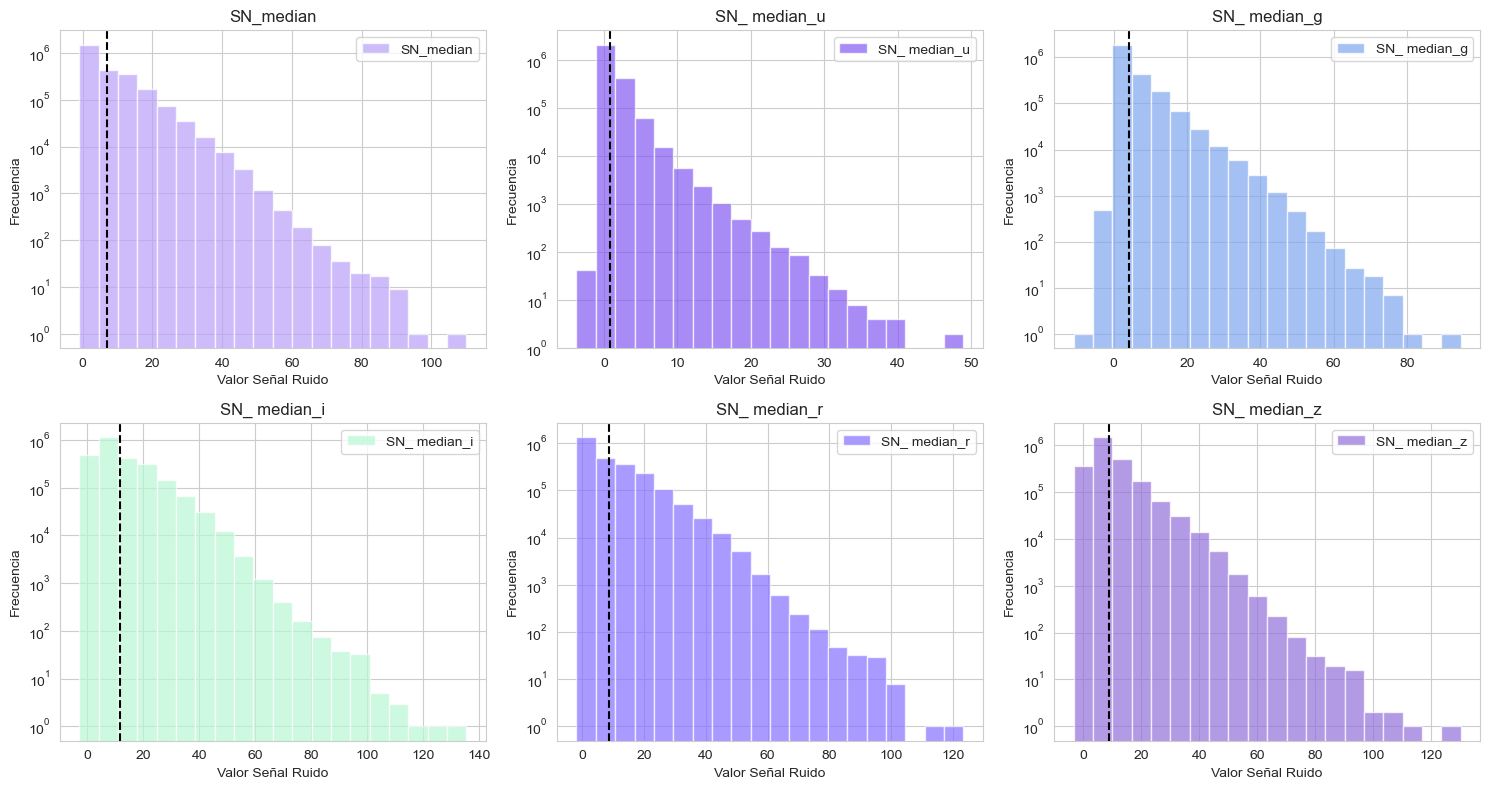

In [79]:
hist_data = [data['snMedian'], data['snMedian_u'], data['snMedian_g'], data['snMedian_i'], data['snMedian_r'], data['snMedian_z']]
colors = ['#BAA0F9', '#835AF1', '#7FA6EE', '#B8F7D4','#8470FF', '#9370DB']
group_labels = ['SN_median', 'SN_ median_u', 'SN_ median_g', 'SN_ median_i', 'SN_ median_r', 'SN_ median_z']

pruebas_init.hist_SN(data, hist_data, group_labels, colors)

# 

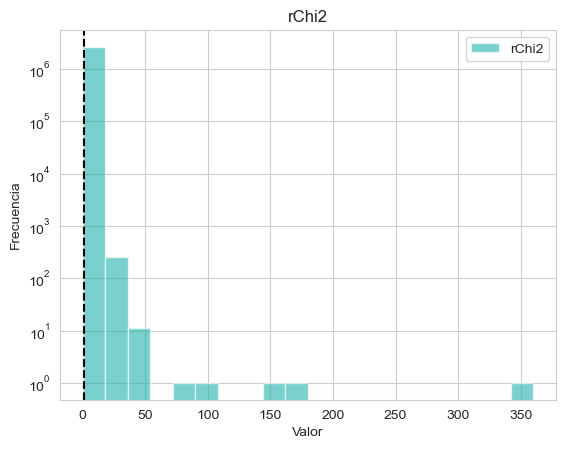

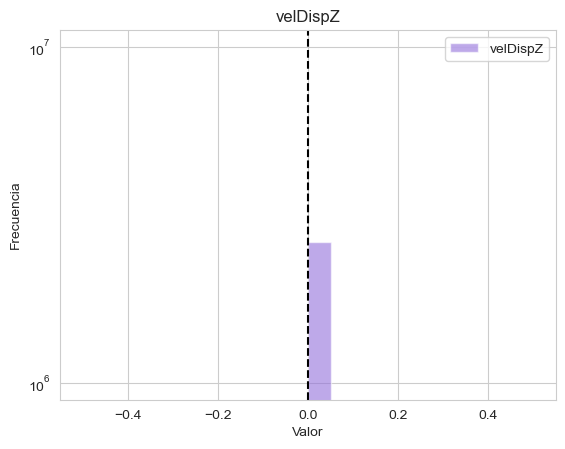

In [80]:
### Chi cuadrado y Dispersion de velocidades
pruebas_init.hist(data['rChi2'], 'lightseagreen', 'rChi2')
pruebas_init.hist(data['velDispZ'], '#9370DB', 'velDispZ')


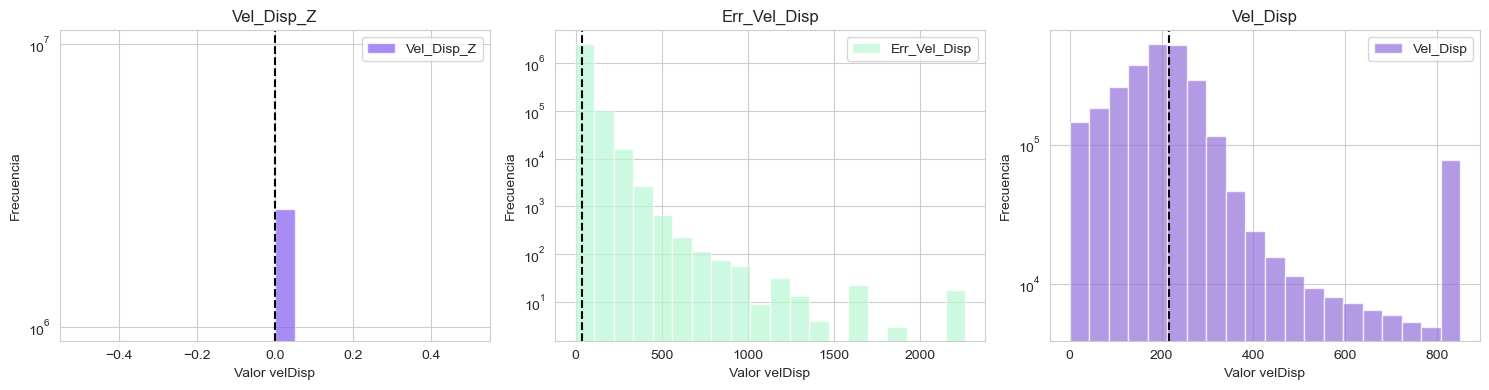

In [81]:
hist_data = [data['velDispZ'], data['velDispErr'], data['velDisp']]
colors = ['#835AF1','#B8F7D4','#9370DB']
group_labels = ['Vel_Disp_Z', 'Err_Vel_Disp', 'Vel_Disp']

pruebas_init.hist_velDisp(data, hist_data, group_labels, colors)

### Limpieza

In [82]:
### Verificar que sean SciencePrimary ###

data['sciencePrimary'].unique()

array([1])

In [83]:
#### drop de los valores -9999.0 ####

data.replace(-9999.0, np.nan, inplace=True)

In [84]:
## Conteo valores NULL ####

acum_g = 0
nulos_g = data['dered_g'].isnull()
for i in range(len(data['dered_g'])):
    if nulos_g[i] == True:
        acum_g += 1

nulos_r = data['dered_r'].isnull()
for i in range(len(data['dered_r'])):
    if nulos_r[i] == True:
        acum_g += 1
acum_g

121

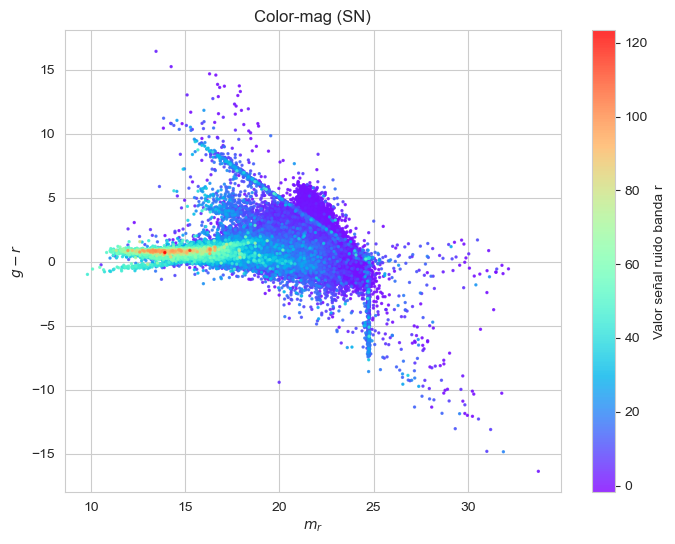

In [85]:
#Limpiando filas de NaNs para estas columnas solamente

data_clean = data.dropna(subset=['dered_r', 'dered_g', 'snMedian_r'])
#len(data_clean)

color = data_clean['dered_g'] - data_clean['dered_r']

#Grafico inicial color-mag con densidades respecto a SN 

graficos.color_mag_SN(data_clean, color, 'r')

1.294311269770933

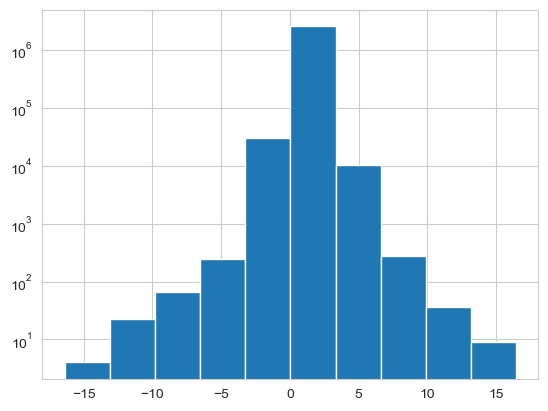

In [86]:
plt.hist(data['dered_g']-data['dered_r'])
plt.yscale('log')
np.mean(data['dered_g']-data['dered_r'])

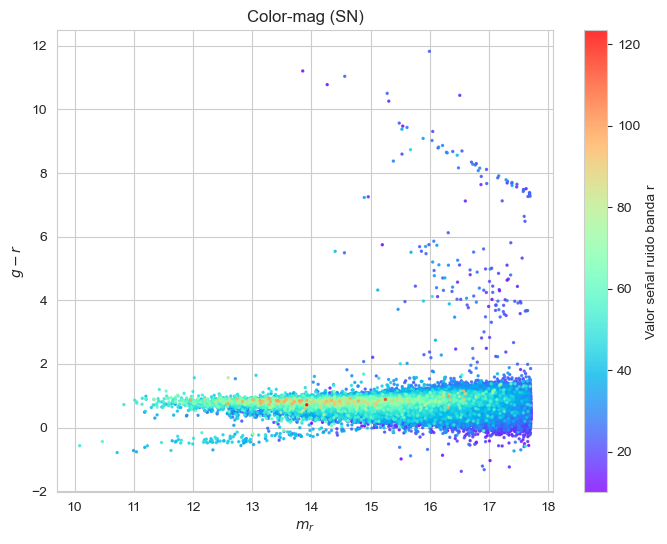

In [87]:
### Restriccion SN > 10  y MAGNITUD LÍMITE###

columnas_a_filtrar = ['snMedian_r', 'snMedian_g']

condicion = pd.Series(False, index=data.index)

for columna in columnas_a_filtrar:
    condicion = condicion | (data[columna] < 10)

data_SN10 = data.loc[condicion]

datos_SN10 = data.drop(data_SN10.index)

data_clean_SN10 = datos_SN10.dropna(subset=['dered_r', 'dered_g', 'snMedian_r'])

## Restricción redshift

condicion_z = condicion | (data_clean_SN10['z'] > 0.05) 

data_sinMagLim = data_clean_SN10.loc[condicion_z] #Data frame sin limpio pero sin restriccion magnitud limite


## Restriccion Magnitud Límite 

condicion_mag_lim = condicion| (data_clean_SN10['dered_r'] < 17.7) ## Restricción magnitud límite

data_clean_SN10 = data_sinMagLim.loc[condicion_mag_lim]


color = data_clean_SN10['dered_g'] - data_clean_SN10['dered_r']


# Grafico

graficos.color_mag_SN(data_clean_SN10, color, 'r')

### Identificación de regiones anómalas

In [88]:
#Columna para las etiquetas por regiones
data_clean_SN10['etiqueta'] = 0

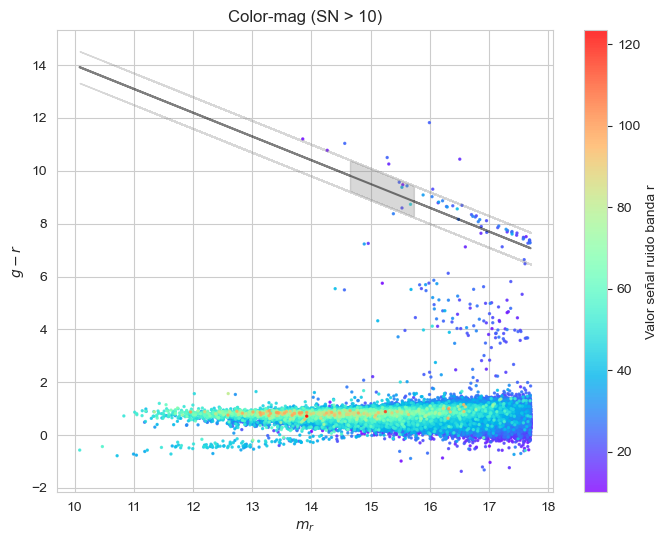

In [89]:
#Region diagonal
graficos.color_mag_SN(data_clean_SN10, color, 'r')

b_diagonal = -0.9*data_clean_SN10['dered_r'] +23
lim_sup = b_diagonal + 0.6
lim_inf = b_diagonal - 0.6

plt.title('Color-mag (SN > 10)')

plt.plot(data_clean_SN10['dered_r'], b_diagonal, color='black', alpha=0.5, label='b_diagonal')
plt.fill_between(data_clean_SN10['dered_r'], lim_sup, lim_inf, color='gray', alpha=0.3, label='Shadowed Path')

plt.show()

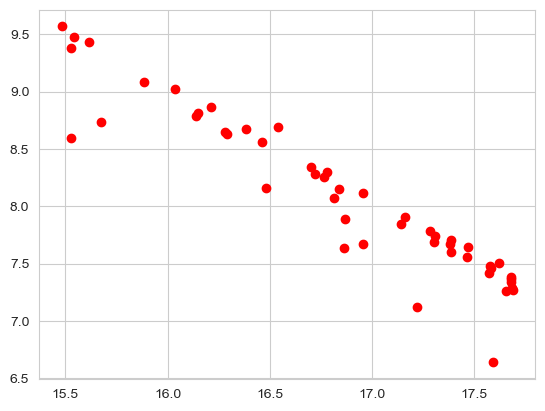

In [90]:
puntos_diagonal = (color <= lim_sup) & (color >= lim_inf) #Puntos dentro de la region delimitada por las rectas diagonales

plt.scatter(data_clean_SN10['dered_r'][puntos_diagonal], color[puntos_diagonal], c='red', label='Points Inside')

#Asignar valor de 1 a la etiqueta de esta zona
data_clean_SN10.loc[puntos_diagonal, 'etiqueta'] = 1

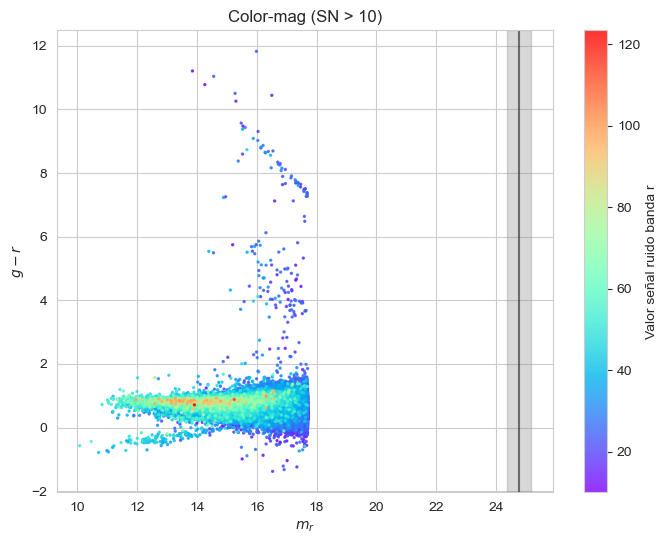

In [91]:
#Region vertical
graficos.color_mag_SN(data_clean_SN10, color, 'r')
plt.title('Color-mag (SN > 10)')

plt.axvline(24.75, color='black', linestyle='-', alpha=0.5)
plt.axvspan(24.75 - 0.4, 24.75 + 0.4, color='gray', alpha=0.3)

plt.show()

(10.0, 30.0)

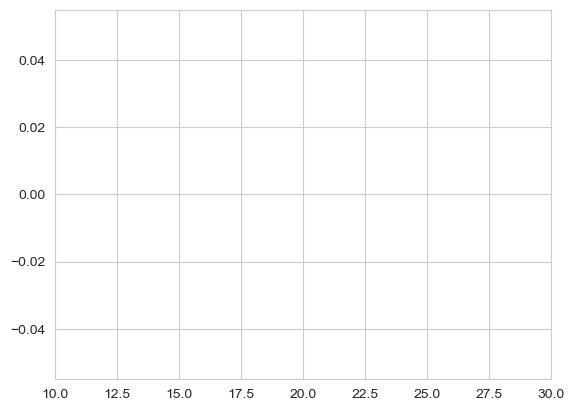

In [92]:
linea_vertical = 24.75

x_range = 0.4 

puntos_vertical = (data_clean_SN10['dered_r'] >= linea_vertical - x_range) & (data_clean_SN10['dered_r'] <= linea_vertical + x_range) #& y < lim_inf

#Asignar valor de 2 a la etiqueta de esta zona
data_clean_SN10.loc[puntos_vertical, 'etiqueta'] = 2

plt.scatter(data_clean_SN10['dered_r'][puntos_vertical], color[puntos_vertical], c='red')
plt.xlim(10,30)


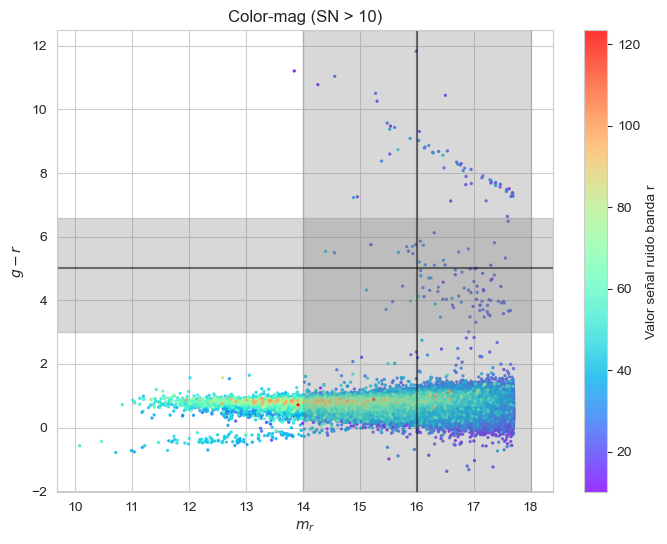

In [93]:
#Region color_5
graficos.color_mag_SN(data_clean_SN10, color, 'r')
plt.title('Color-mag (SN > 10)')

plt.axhline(5, color='black', linestyle='-', alpha=0.5)
plt.axhspan(5 - 2, 5 + 1.6, color='gray', alpha=0.3)
plt.axvline(16, color='black', linestyle='-', alpha=0.5)
plt.axvspan(16 - 2, 16 + 2, color='gray', alpha=0.3)

plt.show()

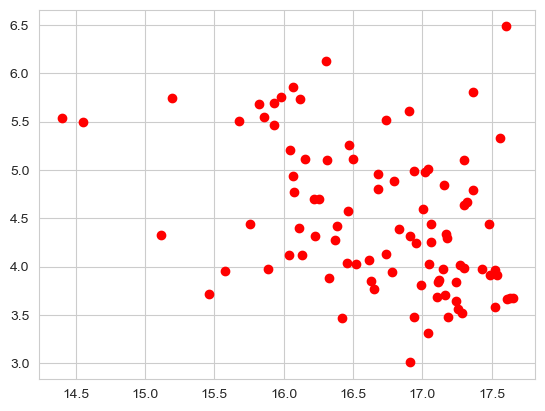

In [94]:
linea_horizontal = 5

y_range = 2 

puntos_color_5 = (color >= linea_horizontal - y_range) & (color <= linea_horizontal + 1.6) & (data_clean_SN10['dered_r']>= 16 - 2) & (data_clean_SN10['dered_r']<= 16 + 2)

#Asignar valor de 3 a la etiqueta de esta zona
data_clean_SN10.loc[puntos_color_5, 'etiqueta'] = 3

plt.scatter(data_clean_SN10['dered_r'][puntos_color_5], color[puntos_color_5], c='red')



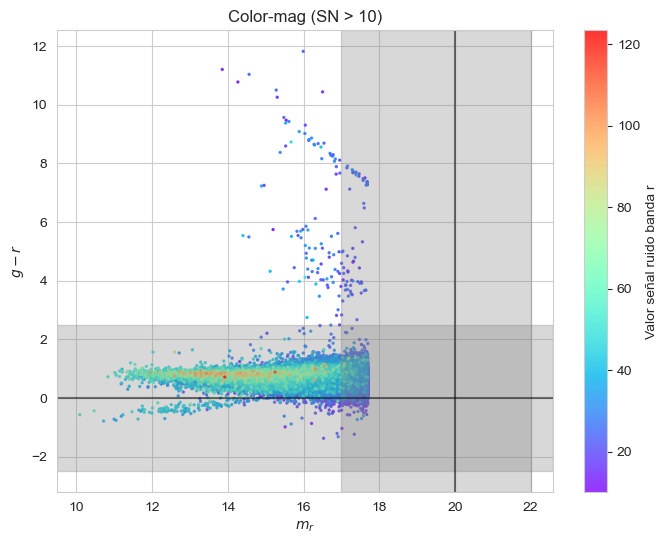

In [95]:
#Region cola
graficos.color_mag_SN(data_clean_SN10, color, 'r')
plt.title('Color-mag (SN > 10)')


plt.axhline(0, color='black', linestyle='-', alpha=0.5)
plt.axhspan(-2.5, 2.5, color='gray', alpha=0.3)
plt.axvline(20, color='black', linestyle='-', alpha=0.5)
plt.axvspan(20 - 3, 20 + 2, color='gray', alpha=0.3)

"""
plt.axhline(0, color='black', linestyle='-', alpha=0.5)
plt.axhspan(-3, 1, color='gray', alpha=0.3)
plt.axvline(23, color='black', linestyle='-', alpha=0.5)
plt.axvspan(23 - 1, 23 + 1 , color='gray', alpha=0.3)
"""
plt.show()

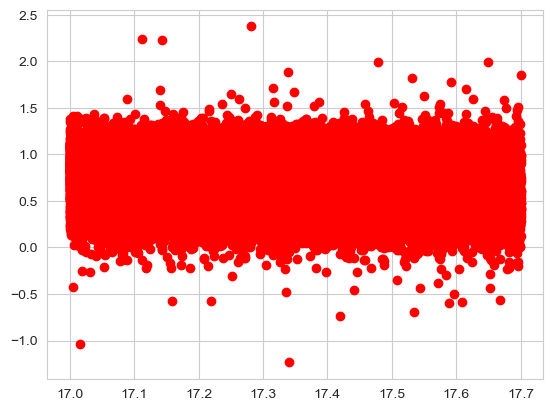

In [96]:
puntos_cola_1 = (color >= -2.5) & (color <= 2.5) & (data_clean_SN10['dered_r']>= 20 - 3) & (data_clean_SN10['dered_r']<= 20 + 2) 
puntos_cola_2 = (color >= -3) & (color <= 1) & (data_clean_SN10['dered_r']>= 23 - 1) & (data_clean_SN10['dered_r']<= 23 + 1)

puntos_cola = puntos_cola_1 | puntos_cola_2

#Asignar valor de 4 a la etiqueta de esta zona
data_clean_SN10.loc[puntos_cola, 'etiqueta'] = 4

plt.scatter(data_clean_SN10['dered_r'][puntos_cola], color[puntos_cola], c='red')



In [97]:
data_clean_SN10['etiqueta'].unique()

array([0, 4, 3, 1])

### Muestreo SN de 20 en 20

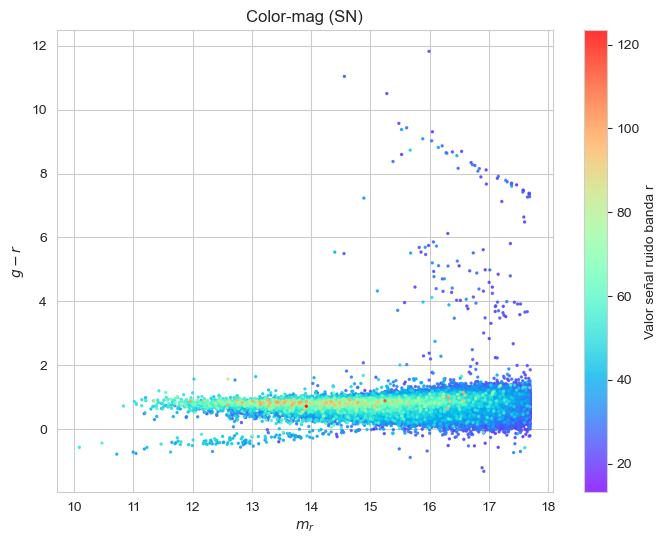

In [98]:
### Datos solo con SN>20 ###
columnas_a_filtrar = ['snMedian_g','snMedian_r']

condicion = pd.Series(False, index=data_clean_SN10.index)

for columna in columnas_a_filtrar:
    condicion = condicion | (data_clean_SN10[columna] > 20)

data_clean_SN20 = data_clean_SN10.loc[condicion]

color = data_clean_SN20['dered_g'] - data_clean_SN20['dered_r']

# Grafico

graficos.color_mag_SN(data_clean_SN20, color, 'r')

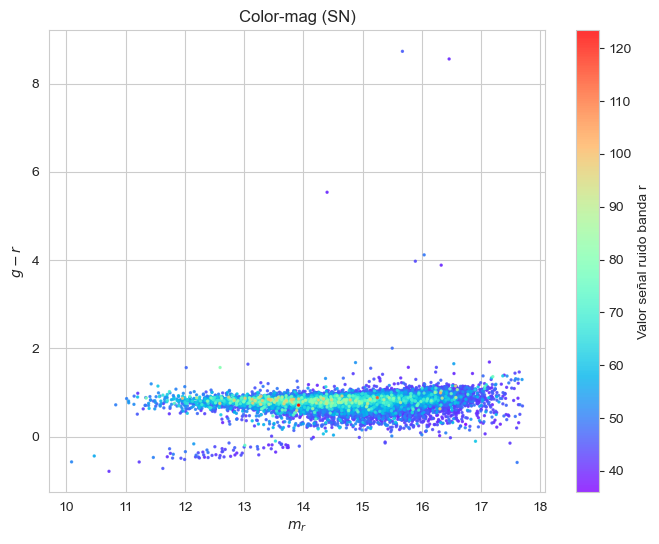

In [99]:
### Datos solo con SN>40 ###
columnas_a_filtrar = ['snMedian_g','snMedian_r']

condicion = pd.Series(False, index=data_clean_SN10.index)

for columna in columnas_a_filtrar:
    condicion = condicion | (data_clean_SN10[columna] > 40)

data_clean_SN40 = data_clean_SN10.loc[condicion]

color = data_clean_SN40['dered_g'] - data_clean_SN40['dered_r']

# Grafico

graficos.color_mag_SN(data_clean_SN40, color, 'r')

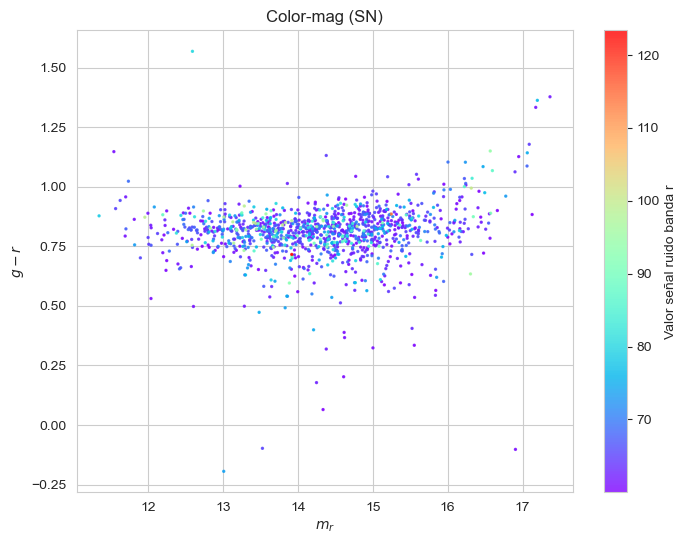

In [100]:
### Datos solo con SN>60 ###
columnas_a_filtrar = ['snMedian_g','snMedian_r']

condicion = pd.Series(False, index=data_clean_SN10.index)

for columna in columnas_a_filtrar:
    condicion = condicion | (data_clean_SN10[columna] > 60)

data_clean_SN60 = data_clean_SN10.loc[condicion]

color = data_clean_SN60['dered_g'] - data_clean_SN60['dered_r']

# Grafico

graficos.color_mag_SN(data_clean_SN60, color, 'r')

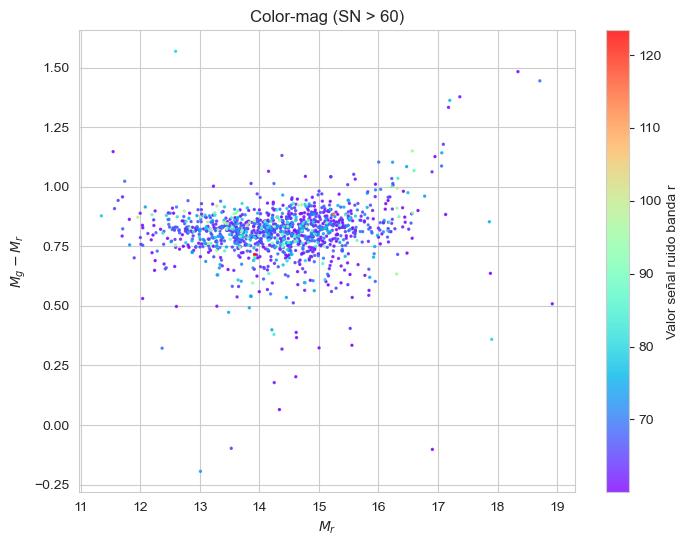

In [101]:
### Datos solo con SN>60 ###
columnas_a_filtrar = ['snMedian_g', 'snMedian_r']

condicion = pd.Series(False, index=datos_SN10.index)

for columna in columnas_a_filtrar:
    condicion = condicion | (datos_SN10[columna] > 60)

data_SN60 = datos_SN10.loc[condicion]

data_clean_SN60 = data_SN60.dropna(subset=['dered_r', 'dered_g', 'snMedian_r'])

y = data_clean_SN60['dered_g'] - data_clean_SN60['dered_r']

#Densidad de puntos basada en snMedian_r
density, _ = np.histogram(data_clean_SN60['snMedian_r'], bins=100, density=True)

#Ordenar los puntos en función de su densidad con respecto a snMedian_r
idx = data_clean_SN60['snMedian_r'].argsort()
dered_r_sorted = data_clean_SN60['dered_r'].values[idx]
y_sorted = y.values[idx]
snMedian_r_sorted = data_clean_SN60['snMedian_r'].values[idx]

plt.figure(figsize=(8,6))
plt.scatter(dered_r_sorted, y_sorted, c=snMedian_r_sorted, cmap='rainbow', s=2, alpha=0.8)

plt.colorbar(label='Valor señal ruido banda r')  
plt.xlabel('$M_r$ ')
plt.ylabel('$M_g - M_r$')
plt.title('Color-mag (SN > 60)')
plt.show()


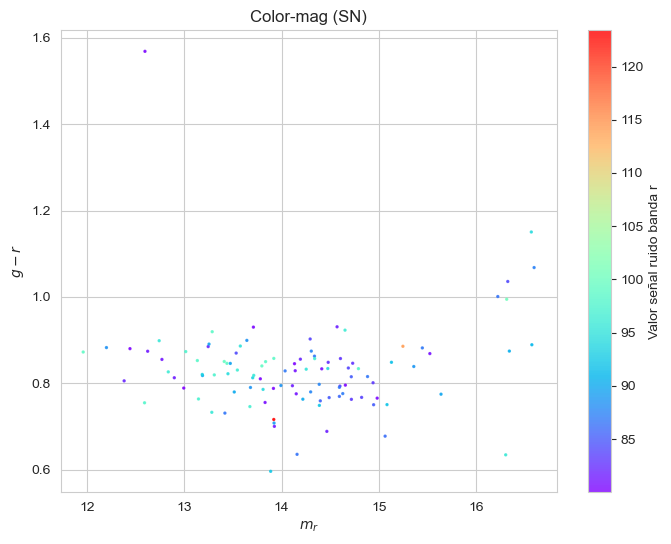

In [102]:
### Datos solo con SN>80 ###
columnas_a_filtrar = ['snMedian_g','snMedian_r']

condicion = pd.Series(False, index=data_clean_SN10.index)

for columna in columnas_a_filtrar:
    condicion = condicion | (data_clean_SN10[columna] > 80)

data_clean_SN80 = data_clean_SN10.loc[condicion]

color = data_clean_SN80['dered_g'] - data_clean_SN80['dered_r']

# Grafico

graficos.color_mag_SN(data_clean_SN80, color, 'r')

# Magnitudes absolutas

### Distancia Comóvil

$r_{i}=c \int_{0}^{z_{i}} \frac{\mathrm{d} z}{H_{0} \sqrt{\Omega_{\mathrm{m}}(1+z)^{3}+\Omega_{\Lambda}}}$

$\Omega_{\mathrm{m}}=0.258$ parámetro de densidad de masa, $H_{0}=72 \mathrm{~km} \mathrm{~s}^{-1} \mathrm{Mpc}^{-1}$ constante de Hubble en el tiempo presente. 

### Magnitud

$M_{x}-5 \log h=m_{x}-D M(z)-K(z)-A_{x}\left(z-z_{n}\right)$

$_x$  para las diferentes bandas $x=$ ( $u, g, r, i, z), M_{x}$ magnitud absoluta, $m_{x}$ magnitud aparente dada por el catálogo, $D M(z)$ módulo de la distancia, $K(z)$ es el término de corrección k, $z_{n}=0.1$ redshift de referencia. Los coeficientes $A_{x}$ cuantifican la corrección por evolución y se toman de Blanton et al. (2003) $A_{x}=$ $(-4.22,-2.04,-1.62,-1.61,-0.76)$ para los cinco colores.

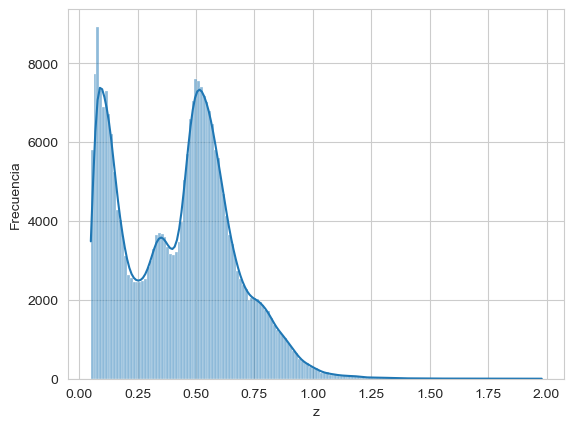

In [103]:
sns.set_style("whitegrid")

sns.histplot(data_clean_SN10['z'], kde=True)

plt.xlabel('z')
plt.ylabel('Frecuencia')
plt.show()

In [104]:
## Calculo Distancias comoviles con el modulo func ###

data_clean_SN10['r_comovil'], data_clean_SN10['r_err'] = func.Dist_Comov(data_clean_SN10['z'], 0, data_clean_SN10['z'] )

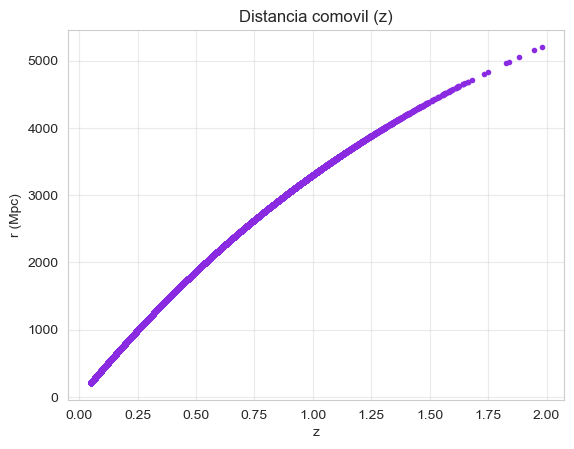

In [105]:
plt.plot( data_clean_SN10['z'], data_clean_SN10['r_comovil'], '.', color='blueviolet')
plt.xlabel('z')
plt.ylabel('r (Mpc)')
plt.title('Distancia comovil (z)')
plt.grid(alpha=0.4)

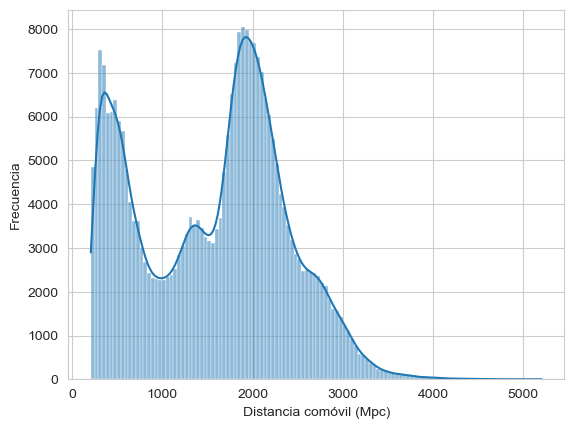

In [106]:
sns.set_style("whitegrid")

sns.histplot(data_clean_SN10['r_comovil'], kde=True)

plt.xlabel('Distancia comóvil (Mpc)')
plt.ylabel('Frecuencia')
plt.show()

In [107]:
## Calculo Modulo de la distancia con el modulo func ###

data_clean_SN10['DM'] = 0

for i in data_clean_SN10.index:
    data_clean_SN10['DM'][i] = func.DistanceModulus(data_clean_SN10['r_comovil'][i])
    

In [108]:
### Calculo de Magnitudes Absolutas con el modulo func ###

h =0.7 

data_clean_SN10['M_r'] = 0
data_clean_SN10['M_g'] = 0

for i in data_clean_SN10.index:
    data_clean_SN10['M_r'][i] = func.M_x(data_clean_SN10['dered_r'][i], data_clean_SN10['DM'][i], 0, 0, data_clean_SN10['z'][i] )
    data_clean_SN10['M_g'][i] = func.M_x(data_clean_SN10['dered_g'][i], data_clean_SN10['DM'][i], 0, 0, data_clean_SN10['z'][i] )

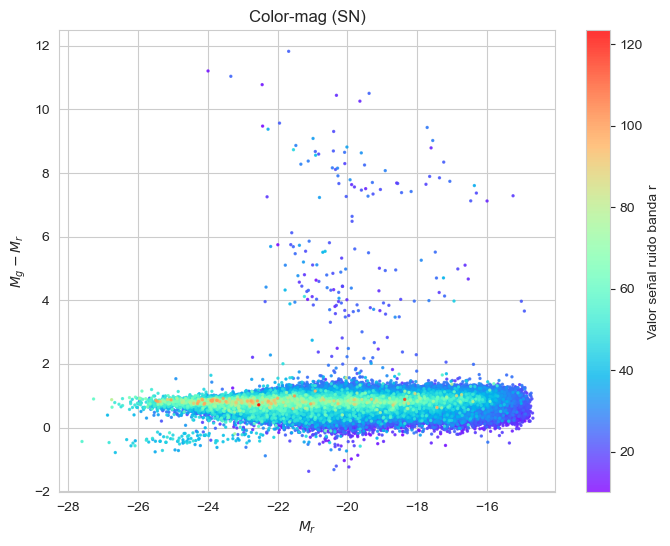

In [109]:
## Asignacion y graficacion ###

M_r = data_clean_SN10['M_r']
M_g = data_clean_SN10['M_g']

m_r =  data_clean_SN10['dered_r']
m_g =  data_clean_SN10['dered_g']

color = m_g - m_r

## Respecto a SN
graficos.color_Mag_SN(data_clean_SN10, color, 'r')


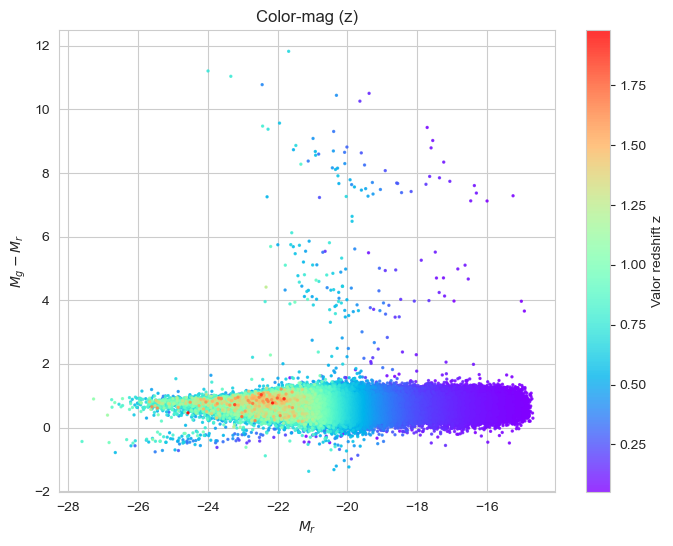

In [110]:
#Respecto a z

graficos.color_Mag_z(data_clean_SN10, color, 'r')

Text(0.5, 1.0, 'Magnitud (z)')

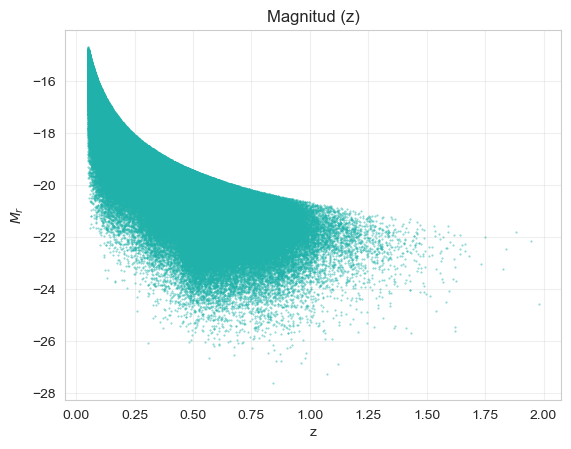

In [111]:
plt.scatter(data_clean_SN10['z'], M_r, color='lightseagreen', alpha =0.6, s=0.2)
plt.grid(alpha=0.3)
plt.xlabel('z')
plt.ylabel('$M_r$')
plt.title('Magnitud (z)')

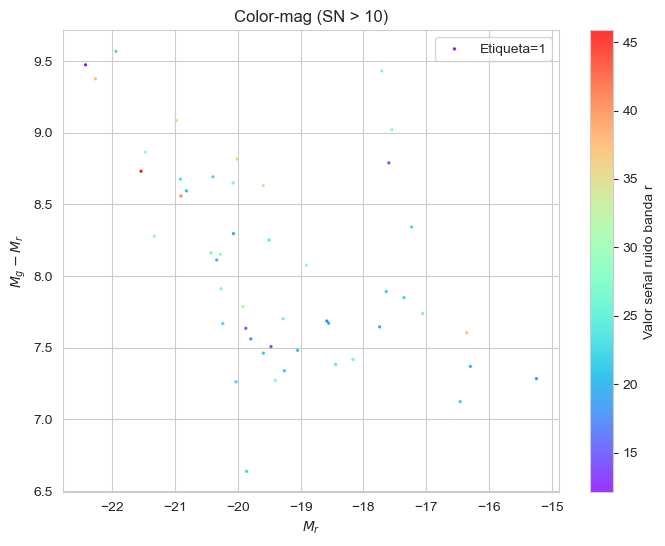

In [112]:
### Las de etiqueta 1###

y = color
density, _ = np.histogram(data_clean_SN10['snMedian_r'], bins=100, density=True)

idx = data_clean_SN10['snMedian_r'].argsort()
dered_r_sorted = data_clean_SN10['M_r'].values[idx]
y_sorted = y.values[idx]
snMedian_r_sorted = data_clean_SN10['snMedian_r'].values[idx]
etiqueta_sorted = data_clean_SN10['etiqueta'].values[idx]


plt.figure(figsize=(8,6))
plt.scatter(dered_r_sorted[etiqueta_sorted == 1], y_sorted[etiqueta_sorted == 1], c=snMedian_r_sorted[etiqueta_sorted == 1], cmap='rainbow', s=2, alpha=0.8, label='Etiqueta=1')

plt.colorbar(label='Valor señal ruido banda r')  
plt.xlabel('$M_r$ ')
plt.ylabel('$M_g - M_r$')
plt.title('Color-mag (SN > 10)')
plt.legend()
plt.show()


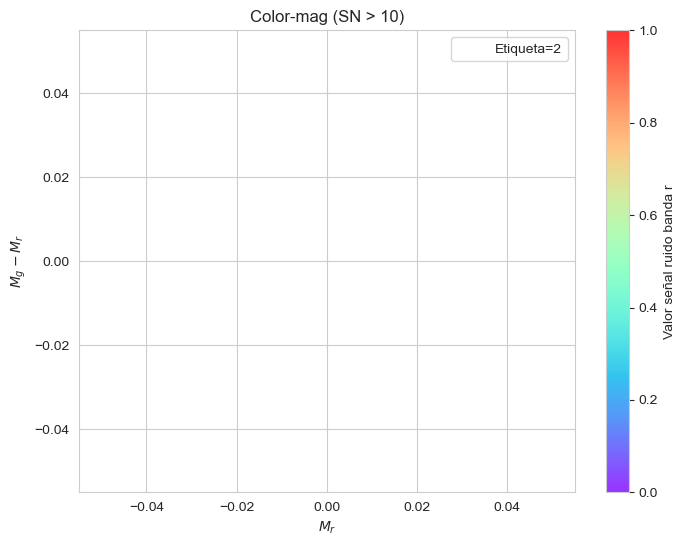

In [113]:
### Las de etiqueta 2 ###

y = color

density, _ = np.histogram(data_clean_SN10['snMedian_r'], bins=100, density=True)

idx = data_clean_SN10['snMedian_r'].argsort()
dered_r_sorted = data_clean_SN10['M_r'].values[idx]
y_sorted = y.values[idx]
snMedian_r_sorted = data_clean_SN10['snMedian_r'].values[idx]
etiqueta_sorted = data_clean_SN10['etiqueta'].values[idx]


plt.figure(figsize=(8,6))
plt.scatter(dered_r_sorted[etiqueta_sorted == 2], y_sorted[etiqueta_sorted == 2], c=snMedian_r_sorted[etiqueta_sorted == 2], cmap='rainbow', s=2, alpha=0.8, label='Etiqueta=2')

plt.colorbar(label='Valor señal ruido banda r')  
plt.xlabel('$M_r$ ')
plt.ylabel('$M_g - M_r$')
plt.title('Color-mag (SN > 10)')
plt.legend()
plt.show()

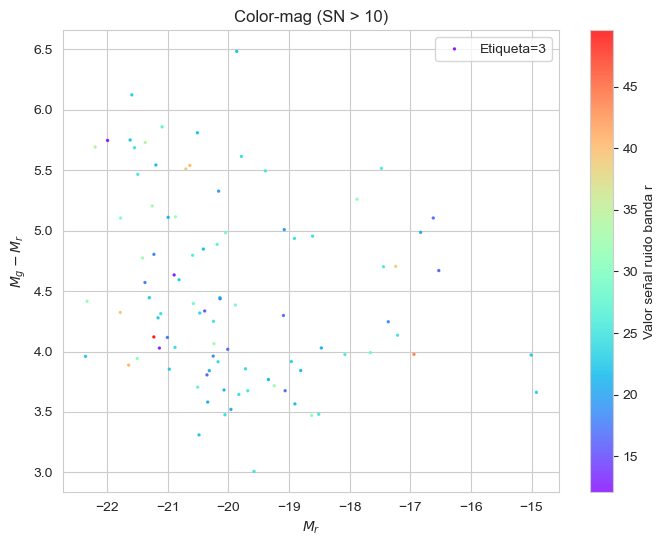

In [114]:
### Las de etiqueta 3 ###

y = color

density, _ = np.histogram(data_clean_SN10['snMedian_r'], bins=100, density=True)

idx = data_clean_SN10['snMedian_r'].argsort()
dered_r_sorted = data_clean_SN10['M_r'].values[idx]
y_sorted = y.values[idx]
snMedian_r_sorted = data_clean_SN10['snMedian_r'].values[idx]
etiqueta_sorted = data_clean_SN10['etiqueta'].values[idx]


plt.figure(figsize=(8,6))
plt.scatter(dered_r_sorted[etiqueta_sorted == 3], y_sorted[etiqueta_sorted == 3], c=snMedian_r_sorted[etiqueta_sorted == 3], cmap='rainbow', s=2, alpha=0.8, label='Etiqueta=3')

plt.colorbar(label='Valor señal ruido banda r')  
plt.xlabel('$M_r$ ')
plt.ylabel('$M_g - M_r$')
plt.title('Color-mag (SN > 10)')
plt.legend()
plt.show()

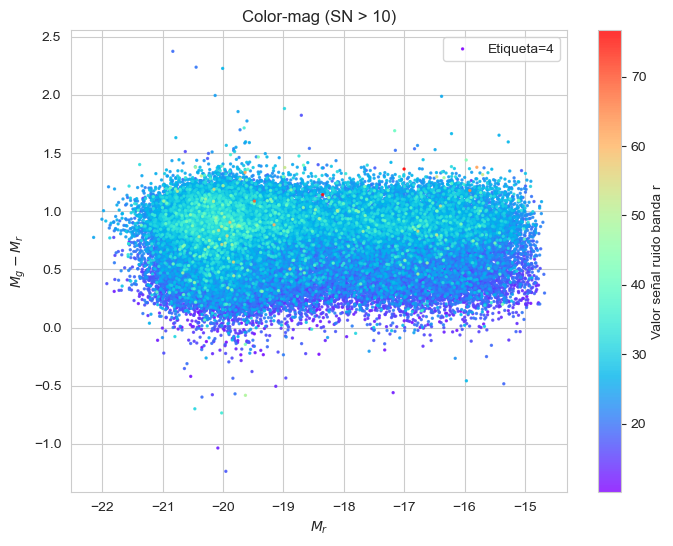

In [115]:
### Las de etiqueta 4 ###

y = color

density, _ = np.histogram(data_clean_SN10['snMedian_r'], bins=100, density=True)

idx = data_clean_SN10['snMedian_r'].argsort()
dered_r_sorted = data_clean_SN10['M_r'].values[idx]
y_sorted = y.values[idx]
snMedian_r_sorted = data_clean_SN10['snMedian_r'].values[idx]
etiqueta_sorted = data_clean_SN10['etiqueta'].values[idx]


plt.figure(figsize=(8,6))
plt.scatter(dered_r_sorted[etiqueta_sorted == 4], y_sorted[etiqueta_sorted == 4], c=snMedian_r_sorted[etiqueta_sorted == 4], cmap='rainbow', s=2, alpha=0.8, label='Etiqueta=4')

plt.colorbar(label='Valor señal ruido banda r')  
plt.xlabel('$M_r$ ')
plt.ylabel('$M_g - M_r$')
plt.title('Color-mag (SN > 10)')
plt.legend()
plt.show()

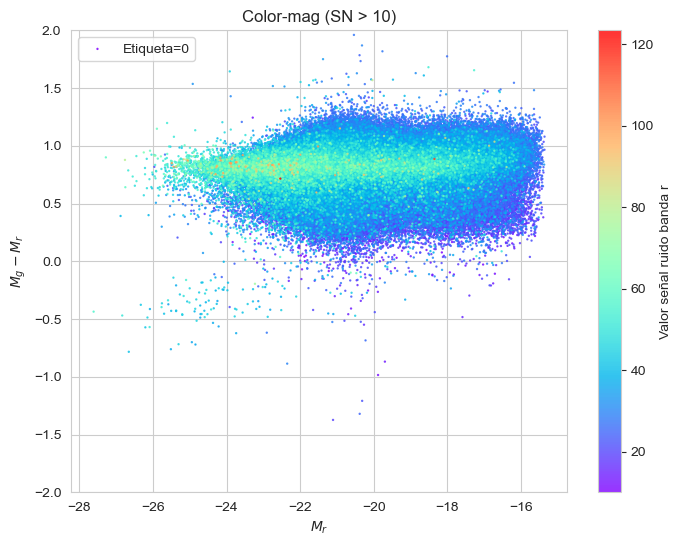

In [116]:
### Las de etiqueta 0 ###

y = color

density, _ = np.histogram(data_clean_SN10['snMedian_r'], bins=100, density=True)

idx = data_clean_SN10['snMedian_r'].argsort()
dered_r_sorted = data_clean_SN10['M_r'].values[idx]
y_sorted = y.values[idx]
snMedian_r_sorted = data_clean_SN10['snMedian_r'].values[idx]
etiqueta_sorted = data_clean_SN10['etiqueta'].values[idx]


plt.figure(figsize=(8,6))
plt.scatter(dered_r_sorted[etiqueta_sorted == 0], y_sorted[etiqueta_sorted == 0], c=snMedian_r_sorted[etiqueta_sorted == 0], cmap='rainbow', s=0.5, alpha=0.8, label='Etiqueta=0')

plt.colorbar(label='Valor señal ruido banda r')  
plt.xlabel('$M_r$ ')
plt.ylabel('$M_g - M_r$')
plt.title('Color-mag (SN > 10)')
plt.ylim(-2, 2)
plt.legend()
plt.show()

## Kcorrect y EC

$A_x = (−4.22, −2.04, −1.62, −1.61, −0.76)$
(u, g, r, i, z)

In [117]:
def EC(A, z, zn):
    return A*(z- zn)

In [118]:
responses = ['sdss_u0', 'sdss_g0', 'sdss_r0', 'sdss_i0', 'sdss_z0']
kc = kcorrect.kcorrect.Kcorrect(responses=responses)
A = np.array([-4.22, -2.04, -1.62, -1.61, -0.76])

#Redshift
redshift = data_clean_SN10['z'].to_numpy()

#Fluxes and fluxes Inverse variance
petroFlux_columns = ['petroFlux_u', 'petroFlux_g', 'petroFlux_r', 'petroFlux_i', 'petroFlux_z']
petroFluxIvar_columns = ['petroFluxIvar_u', 'petroFluxIvar_g', 'petroFluxIvar_r', 'petroFluxIvar_i', 'petroFluxIvar_z']

maggies = data_clean_SN10[petroFlux_columns].to_numpy()

ivar = data_clean_SN10[petroFluxIvar_columns].to_numpy()


coeffs = kc.fit_coeffs(redshift=redshift, maggies=maggies, ivar=ivar)

#K-corrections in magnitude units
k = kc.kcorrect(redshift=redshift, coeffs=coeffs)

absmag = kc.absmag(redshift=redshift, maggies=maggies, ivar=ivar, coeffs=coeffs)


 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.

 NNLS quitting on iteration count.


In [119]:
data_clean_SN10['M_r_kcorrect'] = absmag[:,2]
data_clean_SN10['M_g_kcorrect'] = absmag[:,1]

data_clean_SN10['kcorrect_r'] = k[:,2]
data_clean_SN10['kcorrect_g'] = k[:,1]

In [120]:
y = data_clean_SN10['M_g_kcorrect'] - data_clean_SN10['M_r_kcorrect']

data_clean_SN10['M_r_kcorrect'], y

(6         -41.912010
 9         -45.468376
 44        -46.132458
 52        -48.658325
 82        -46.431900
              ...    
 2617687   -41.417374
 2617704   -40.549763
 2617771   -47.518444
 2617772   -46.598301
 2617777   -38.408802
 Name: M_r_kcorrect, Length: 288931, dtype: float32,
 6             0.386730
 9             1.081257
 44            1.336990
 52            0.410290
 82           -0.004524
               ...     
 2617687   -9957.583008
 2617704       1.362637
 2617771       1.159477
 2617772       0.763084
 2617777       0.418194
 Length: 288931, dtype: float32)

(-50.0, 50.0)

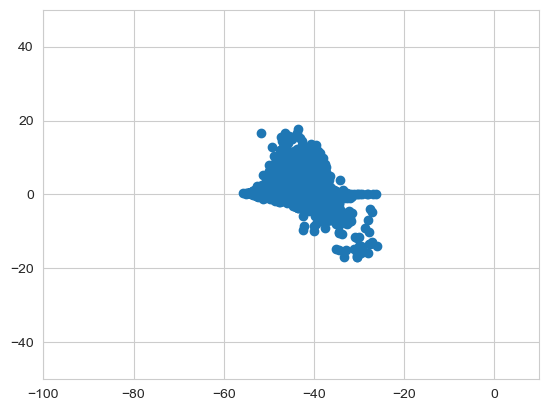

In [121]:
plt.scatter(data_clean_SN10['M_r_kcorrect'], y)
plt.xlim(-100,10)
plt.ylim(-50,50)

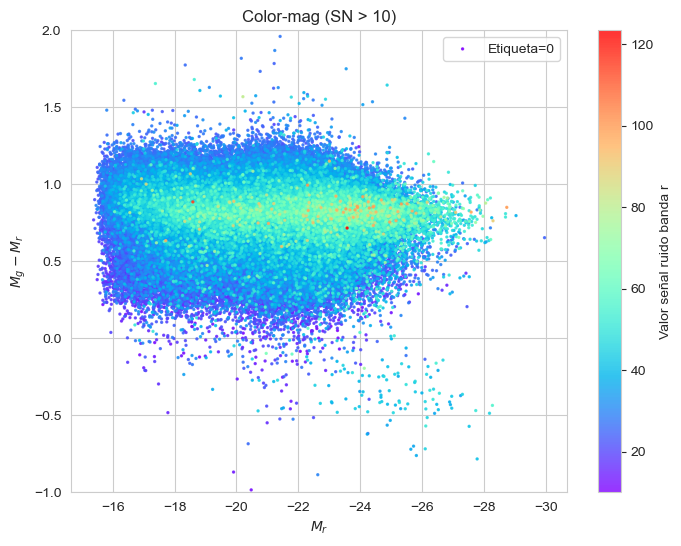

In [122]:
### Graficando con las magnitudes anteriores y la correccion K nueva obtenida ###
### Las de etiqueta 0 ###
zn = 0.1

corr_r =  data_clean_SN10['kcorrect_r'] 
 
corr_g = data_clean_SN10['kcorrect_g']

#Nuevas magnitudes
M_g_corr = M_g - corr_g #- EC(A[1], data_clean_SN10['z'], zn )

M_r_corr = M_r - corr_r #- EC(A[2], data_clean_SN10['z'], zn )

color_gr = m_g - m_r


### Grafico ####
density, _ = np.histogram(data_clean_SN10['snMedian_r'], bins=100, density=True)

idx = data_clean_SN10['snMedian_r'].argsort()
dered_r_sorted = M_r_corr.values[idx]
y_sorted = color_gr.values[idx]
snMedian_r_sorted = data_clean_SN10['snMedian_r'].values[idx]
etiqueta_sorted = data_clean_SN10['etiqueta'].values[idx]


plt.figure(figsize=(8,6))
plt.scatter(dered_r_sorted[etiqueta_sorted == 0], y_sorted[etiqueta_sorted == 0], c=snMedian_r_sorted[etiqueta_sorted == 0], cmap='rainbow', s=2, alpha=0.8, label='Etiqueta=0')

plt.colorbar(label='Valor señal ruido banda r')  
plt.xlabel('$M_r$ ')
plt.ylabel('$M_g - M_r$')
plt.title('Color-mag (SN > 10)')
plt.ylim(-1,2)
plt.gca().invert_xaxis()
plt.legend()
plt.show()

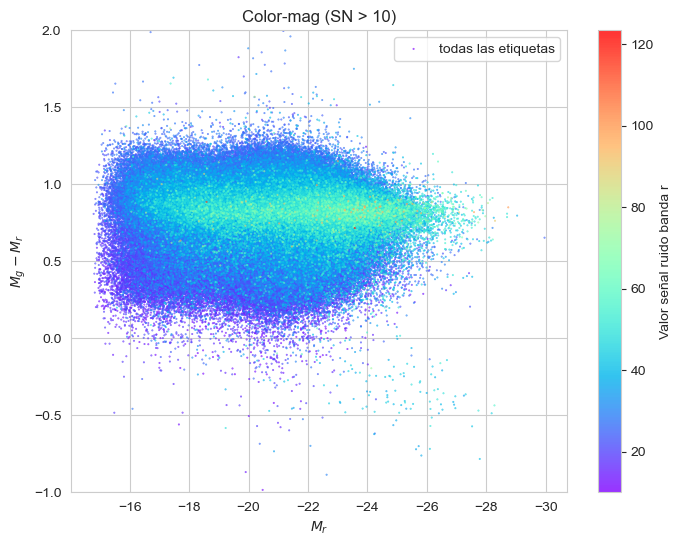

In [123]:
### Graficando con las magnitudes anteriores y la correccion K nueva obtenida ###
### Las todas las etiquetas ###

### Grafico ####
density, _ = np.histogram(data_clean_SN10['snMedian_r'], bins=100, density=True)

idx = data_clean_SN10['snMedian_r'].argsort()
dered_r_sorted = M_r_corr.values[idx]
y_sorted = color_gr.values[idx]
snMedian_r_sorted = data_clean_SN10['snMedian_r'].values[idx]
etiqueta_sorted = data_clean_SN10['etiqueta'].values[idx]


plt.figure(figsize=(8,6))
plt.scatter(dered_r_sorted, y_sorted, c=snMedian_r_sorted, cmap='rainbow', s=0.2, alpha=0.8, label='todas las etiquetas')

plt.colorbar(label='Valor señal ruido banda r')  
plt.xlabel('$M_r$ ')
plt.ylabel('$M_g - M_r$')
plt.title('Color-mag (SN > 10)')
plt.ylim(-1,2)
plt.gca().invert_xaxis()
plt.legend()
plt.show()

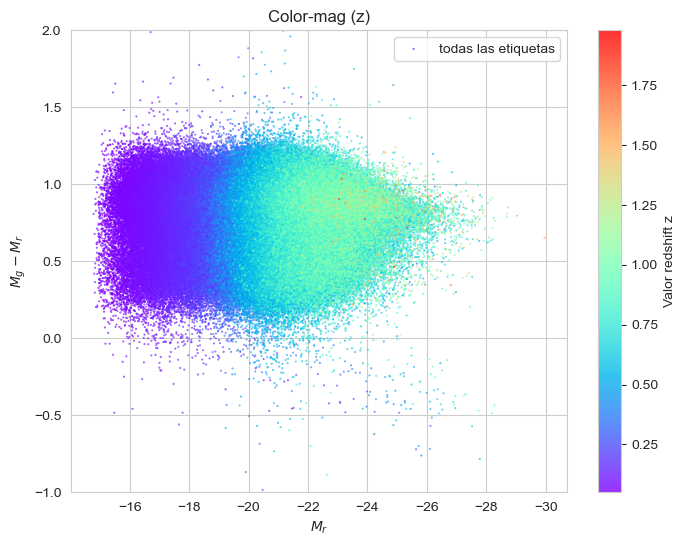

In [124]:
### Graficando con las magnitudes anteriores y la correccion K nueva obtenida ###
### Las todas las etiquetas ###

### Grafico ####
density, _ = np.histogram(data_clean_SN10['z'], bins=100, density=True)

idx = data_clean_SN10['z'].argsort()
dered_r_sorted = M_r_corr.values[idx]
y_sorted = color_gr.values[idx]
redshift_sorted = data_clean_SN10['z'].values[idx]
etiqueta_sorted = data_clean_SN10['etiqueta'].values[idx]


plt.figure(figsize=(8,6))
plt.scatter(dered_r_sorted, y_sorted, c=redshift_sorted, cmap='rainbow', s=0.2, alpha=0.8, label='todas las etiquetas')

plt.colorbar(label='Valor redshift z')  
plt.xlabel('$M_r$ ')
plt.ylabel('$M_g - M_r$')
plt.title('Color-mag (z)')
plt.ylim(-1,2)
plt.gca().invert_xaxis()
plt.legend()
plt.show()

#### Para los flujos modelFlux:

In [125]:
#Fluxes and fluxes Inverse variance
modelFlux_columns = ['modelFlux_u', 'modelFlux_g', 'modelFlux_r', 'modelFlux_i', 'modelFlux_z']
modelFluxIvar_columns = ['modelFluxIvar_u', 'modelFluxIvar_g', 'modelFluxIvar_r', 'modelFluxIvar_i', 'modelFluxIvar_z']

maggies = data_clean_SN10[modelFlux_columns].to_numpy()

ivar = data_clean_SN10[modelFluxIvar_columns].to_numpy()

coeffs = kc.fit_coeffs(redshift=redshift, maggies=maggies, ivar=ivar)

#K-corrections in magnitude units
k = kc.kcorrect(redshift=redshift, coeffs=coeffs)

absmag = kc.absmag(redshift=redshift, maggies=maggies, ivar=ivar, coeffs=coeffs)


### Nuevas columnas ###

data_clean_SN10['M_r_kcorrect_modelFlux'] = absmag[:,2]
data_clean_SN10['M_g_kcorrect_modelFlux'] = absmag[:,1]

data_clean_SN10['kcorrect_r_modelFlux'] = k[:,2]
data_clean_SN10['kcorrect_g_modelFlux'] = k[:,1]


 NNLS quitting on iteration count.

 NNLS quitting on iteration count.


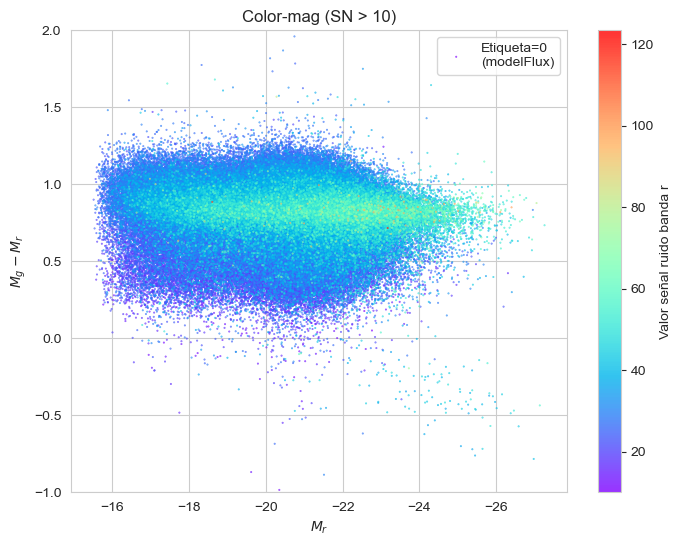

In [126]:
### Graficando con las magnitudes anteriores y la correccion K nueva obtenida ###
### Las de etiqueta 0 ###

corr_r =  data_clean_SN10['kcorrect_r_modelFlux'] 
 
corr_g = data_clean_SN10['kcorrect_g_modelFlux']

#Nuevas magnitudes
M_g_corr = M_g - corr_g - EC(A[1], data_clean_SN10['z'], zn )

M_r_corr = M_r - corr_r - EC(A[2], data_clean_SN10['z'], zn )

color_gr = color


### Grafico ####
density, _ = np.histogram(data_clean_SN10['snMedian_r'], bins=100, density=True)

idx = data_clean_SN10['snMedian_r'].argsort()
dered_r_sorted = M_r_corr.values[idx]
y_sorted = color_gr.values[idx]
snMedian_r_sorted = data_clean_SN10['snMedian_r'].values[idx]
etiqueta_sorted = data_clean_SN10['etiqueta'].values[idx]


plt.figure(figsize=(8,6))
plt.scatter(dered_r_sorted[etiqueta_sorted == 0], y_sorted[etiqueta_sorted == 0], c=snMedian_r_sorted[etiqueta_sorted == 0], cmap='rainbow', s=0.2, alpha=0.8, label='Etiqueta=0\n(modelFlux)')

plt.colorbar(label='Valor señal ruido banda r')  
plt.xlabel('$M_r$ ')
plt.ylabel('$M_g - M_r$')
plt.title('Color-mag (SN > 10)')
plt.ylim(-1,2)
plt.gca().invert_xaxis()
plt.legend()
plt.show()

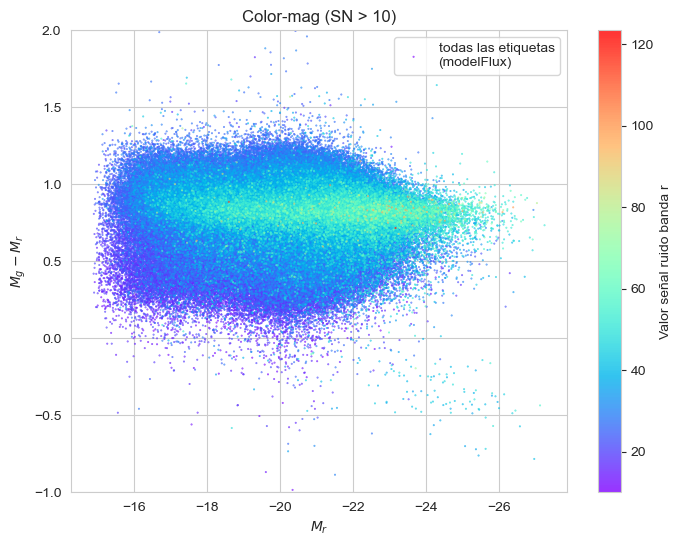

In [127]:
### Graficando con las magnitudes anteriores y la correccion K nueva obtenida ###
### Las todas las etiquetas ###

### Grafico ####
density, _ = np.histogram(data_clean_SN10['snMedian_r'], bins=100, density=True)

idx = data_clean_SN10['snMedian_r'].argsort()
dered_r_sorted = M_r_corr.values[idx]
y_sorted = color_gr.values[idx]
snMedian_r_sorted = data_clean_SN10['snMedian_r'].values[idx]
etiqueta_sorted = data_clean_SN10['etiqueta'].values[idx]


plt.figure(figsize=(8,6))
plt.scatter(dered_r_sorted, y_sorted, c=snMedian_r_sorted, cmap='rainbow', s=0.2, alpha=0.8, label='todas las etiquetas\n(modelFlux)')

plt.colorbar(label='Valor señal ruido banda r')  
plt.xlabel('$M_r$ ')
plt.ylabel('$M_g - M_r$')
plt.title('Color-mag (SN > 10)')
plt.ylim(-1,2)
plt.gca().invert_xaxis()
plt.legend()
plt.show()

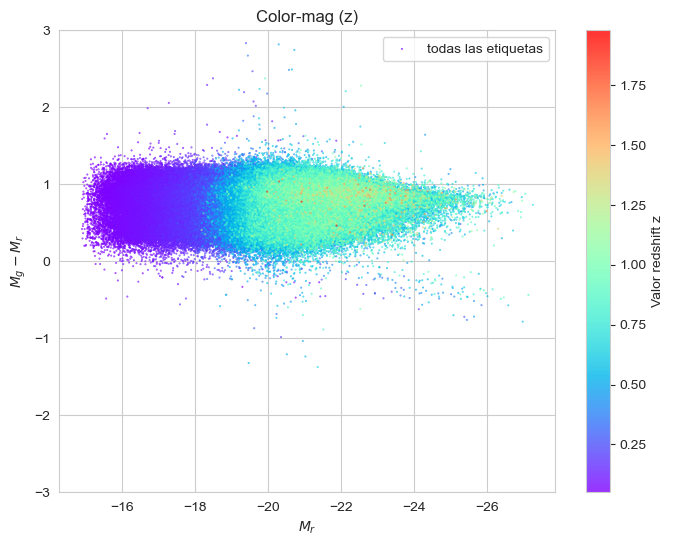

In [128]:
### Graficando con las magnitudes anteriores y la correccion K nueva obtenida ###
### Las todas las etiquetas ###

### Grafico ####
density, _ = np.histogram(data_clean_SN10['z'], bins=100, density=True)

idx = data_clean_SN10['z'].argsort()
dered_r_sorted = M_r_corr.values[idx]
y_sorted = color_gr.values[idx]
redshift_sorted = data_clean_SN10['z'].values[idx]
etiqueta_sorted = data_clean_SN10['etiqueta'].values[idx]


plt.figure(figsize=(8,6))
plt.scatter(dered_r_sorted, y_sorted, c=redshift_sorted, cmap='rainbow', s=0.2, alpha=0.8, label='todas las etiquetas')

plt.colorbar(label='Valor redshift z')  
plt.xlabel('$M_r$ ')
plt.ylabel('$M_g - M_r$')
plt.title('Color-mag (z)')
plt.ylim(-3,3)
plt.gca().invert_xaxis()
plt.legend()
plt.show()

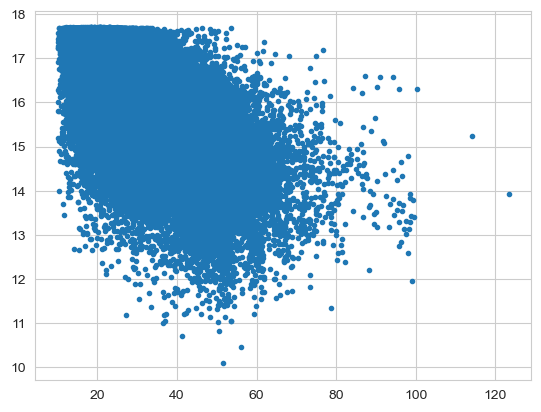

In [129]:
plt.plot(data_clean_SN10['snMedian_r'], data_clean_SN10['dered_r'], '.')

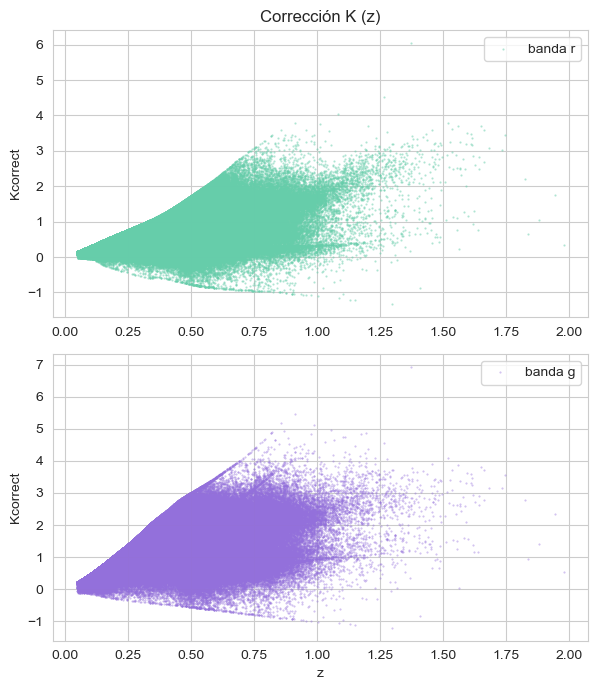

In [130]:
fig, axs = plt.subplots(2, 1, figsize=(6, 7))


axs[0].scatter(data_clean_SN10['z'], corr_r, s=0.3, alpha=0.5, label='banda r', color='#66cdaa')
axs[0].set_ylabel('Kcorrect')
axs[0].set_title('Corrección K (z)')
axs[0].legend()

axs[1].scatter(data_clean_SN10['z'], corr_g, s=0.2, alpha=0.5, label='banda g', color='#9370db')
axs[1].set_xlabel('z')
axs[1].set_ylabel('Kcorrect')
axs[1].legend()

plt.tight_layout()
plt.show()

In [131]:
data_clean_SN10['specObjId']
#specObjId_col = data_clean_SN10['specObjId'].astype(str)

#specObjId_col.to_csv('specObjId.csv', index=False, header=True)

6          1620254128968067072
9          1618058130090911744
44         7452592724291901440
52         1515465994879920128
82          932279796354803712
                  ...         
2617687    1533552140348319744
2617704    5838921971006724096
2617771    2016570367610480640
2617772    2016570642488387584
2617777    2016583011994200064
Name: specObjId, Length: 288931, dtype: uint64

In [157]:
bigint_min = -2**63
bigint_max = 2**63 - 1

# Filter values within the bigint range
valid_specObjIds = data_clean_SN10[
    (data_clean_SN10['specObjId'] >= bigint_min) &
    (data_clean_SN10['specObjId'] <= bigint_max)
]

specObjId_valid = valid_specObjIds['specObjId'].astype(str)

specObjId_valid.to_csv('specObjId.csv', index=False, header=True)

specObjId_valid


6          1620254128968067072
9          1618058130090911744
44         7452592724291901440
52         1515465994879920128
82          932279796354803712
                  ...         
2617687    1533552140348319744
2617704    5838921971006724096
2617771    2016570367610480640
2617772    2016570642488387584
2617777    2016583011994200064
Name: specObjId, Length: 288110, dtype: object

In [134]:
lineas = pd.read_csv('Lineas.csv')
lineas['reliable'].unique()
#lineas.to_excel('lineas.xlsx', index=False)
lineas['hei_5876_flux_err'][2]

2.223635

In [136]:
#Cantidad de líneas confiables y no confiables
lineas['reliable'].value_counts()

1    251804
Name: reliable, dtype: int64

In [137]:
#filtrar las lineas no confiables del dataframe

columnas_a_filtrar = ['reliable']

condicion = pd.Series(False, index=lineas.index)

for columna in columnas_a_filtrar:
    condicion = condicion | (lineas[columna] == 1)

lineas_reliable = lineas.loc[condicion]

Lineas = lineas_reliable

In [152]:
### Duplicados

duplicates_data_clean_SN10 = data_clean_SN10[data_clean_SN10.duplicated(subset='specObjId', keep=False)]

duplicates_lineas = lineas[lineas.duplicated(subset='specObjId', keep=False)]

print("Duplicates in data_clean_SN10:")
print(duplicates_data_clean_SN10)

print("\nDuplicates in lineas:")
print(duplicates_lineas)

Duplicates in data_clean_SN10:
Empty DataFrame
Columns: [targetObjId, specObjId, plateID, targetType, platerun, mjd, fiberId, plate, tile, ra, dec, subClass, rChi2, velDispZ, velDispErr, velDisp, snMedian, snMedian_u, snMedian_g, snMedian_i, snMedian_r, snMedian_z, err_u, err_g, err_r, err_i, err_z, dered_u, dered_g, dered_r, dered_i, dered_z, flags_photo, sciencePrimary, z, zErr, petroFlux_u, petroFlux_g, petroFlux_r, petroFlux_i, petroFlux_z, petroFluxIvar_u, petroFluxIvar_g, petroFluxIvar_r, petroFluxIvar_i, petroFluxIvar_z, modelFlux_u, modelFlux_g, modelFlux_r, modelFlux_i, modelFlux_z, modelFluxIvar_u, modelFluxIvar_g, modelFluxIvar_r, modelFluxIvar_i, modelFluxIvar_z, etiqueta, r_comovil, r_err, DM, M_r, M_g, M_r_kcorrect, M_g_kcorrect, kcorrect_r, kcorrect_g, M_r_kcorrect_modelFlux, M_g_kcorrect_modelFlux, kcorrect_r_modelFlux, kcorrect_g_modelFlux]
Index: []

Duplicates in lineas:
Empty DataFrame
Columns: [oii_3726_flux, oii_3726_flux_err, oii_3729_flux, oii_3729_flux_err, oii

In [156]:
#Lineas faltantes del dataframe limpio
faltantes_lineas = data_clean_SN10['specObjId'][~data_clean_SN10['specObjId'].isin(lineas['specObjId'])]

faltantes_lineas_confiables = data_clean_SN10['specObjId'][~data_clean_SN10['specObjId'].isin(lineas_reliable['specObjId'])]

faltantes_lineas_confiables

## Hacer un experimento independiente en lugar de usar el isin 
## Buscar specobjid repetidos

44         7452592724291901440
186        5818784135599380480
218        5022860035291895808
699        6082232892238616576
783        5441699195177424896
                  ...         
2616679    6147635693374167040
2616996    5146658992920221696
2617513    6067685529205626880
2617514    6067686903595161600
2617704    5838921971006724096
Name: specObjId, Length: 37127, dtype: uint64

In [154]:
matching_ids = data_clean_SN10[data_clean_SN10['specObjId'].isin(lineas['specObjId'])]

# Print the results
print("Matching specObjIds:")
matching_ids['specObjId']

Matching specObjIds:


6          1620254128968067072
9          1618058130090911744
52         1515465994879920128
82          932279796354803712
83          932300687075731456
                  ...         
2617686    1533555164005296128
2617687    1533552140348319744
2617771    2016570367610480640
2617772    2016570642488387584
2617777    2016583011994200064
Name: specObjId, Length: 251804, dtype: uint64

In [158]:
data_clean_SN10_column = data_clean_SN10['specObjId'].astype(str)
lineas_column = lineas['specObjId'].astype(str)


results = np.zeros(len(data_clean_SN10_column), dtype=object)


for i in range(len(data_clean_SN10_column)):
    #if np.mod(1,1000) == 0
    #print(voy en... ,i)
    for j in range(len(lineas_column)):
        if data_clean_SN10_column[i] == lineas_column[j]:
            results[i] = data_clean_SN10_column[i]

results


KeyError: 0

In [144]:
matching_ids = pd.merge(data_clean_SN10, lineas, on='specObjId')

matching_ids['specObjId']


0         1620254128968067072
1         1618058130090911744
2         1515465994879920128
3          932279796354803712
4          932300687075731456
                 ...         
251799    1533555164005296128
251800    1533552140348319744
251801    2016570367610480640
251802    2016570642488387584
251803    2016583011994200064
Name: specObjId, Length: 251804, dtype: uint64

In [145]:
Lineas

oii_3726_flux  oii_3726_flux_err  oii_3729_flux  oii_3729_flux_err  \
0            0.000000          -0.764372       0.000000          -0.764372   
1           39.057380           7.645567      27.096570           7.928473   
2           39.724690           5.439280      24.544130           5.165951   
3           86.114950           8.038120      59.704310           8.036137   
4           40.865940           5.342880      20.076450           5.086627   
...               ...                ...            ...                ...   
251799      11.163110           4.481339      11.807490           4.506737   
251800      18.342260           2.972998       9.916848           2.900549   
251801       1.162094           3.139017       2.326743           3.176558   
251802      36.411010           9.206394      59.867770           9.298899   
251803       8.468143           3.101217       1.940395           2.939687   

        oiii_4363_flux  oiii_4363_flux_err  h_beta_flux  h_beta_flux_err  \
0            14.544610            6.551525   119.495600         6.650275   
1             0.903860            3.333012    25.640470         2.906838   
2             4.085536            2.711077    46.948430         2.555190   
3            -2.701401            3.585219    91.710970         3.794378   
4             0.837469            2.693231    66.982060         2.776938   
...                ...                 ...          ...              ...   
251799        1.040176            2.387731     8.440693         2.376312   
251800       -1.211788            1.922055    19.759210         1.660344   
251801        5.318205            2.496917     1.761674         2.054091   
251802       -0.286717            2.622324    17.035000         2.706483   
251803       -0.573139            2.335688     5.930055         2.205825   

        oiii_4959_flux  oiii_4959_flux_err  oiii_5007_flux  \
0            24.923760            6.301541       68.396060   
1             9.876856            3.281264       21.444370   
2             5.995210            2.540658       14.431690   
3            12.823550            3.802169       55.355480   
4             9.167424            2.581069       18.083990   
...                ...                 ...             ...   
251799        1.727405            2.464693       10.483140   
251800        4.328686            1.659969        6.198793   
251801        6.303130            2.329841        3.382865   
251802       11.064350            3.047439       20.507730   
251803        7.635008            2.682013       18.444440   

        oiii_5007_flux_err  hei_5876_flux  hei_5876_flux_err  oi_6300_flux  \
0                 6.610639       1.524161           6.345315     18.594930   
1                 3.302969       2.559047           2.745098      8.490424   
2                 2.634010       6.942476           2.223635      4.169487   
3                 3.821943      13.368020           3.493399     19.599120   
4                 2.641367       7.899077           2.307124      7.274137   
...                    ...            ...                ...           ...   
251799            2.584692      -2.855752           2.387169      2.361801   
251800            1.672790       1.478914           1.750965      4.500745   
251801            2.262551      -2.434133           2.524924     -0.224705   
251802            3.291787       0.902155           2.318509     16.157730   
251803            2.889542       3.379967           2.348729      2.426250   

        oi_6300_flux_err  nii_6548_flux  nii_6548_flux_err  h_alpha_flux  \
0               6.560489      74.302520           2.802658     472.59040   
1               2.520172      17.104640           1.046200      99.40005   
2               1.857638      24.657880           0.850617     206.21260   
3               3.269828     121.965600           1.824041     510.66470   
4               2.007208      49.037670           1.041202     351.30450   
...                 

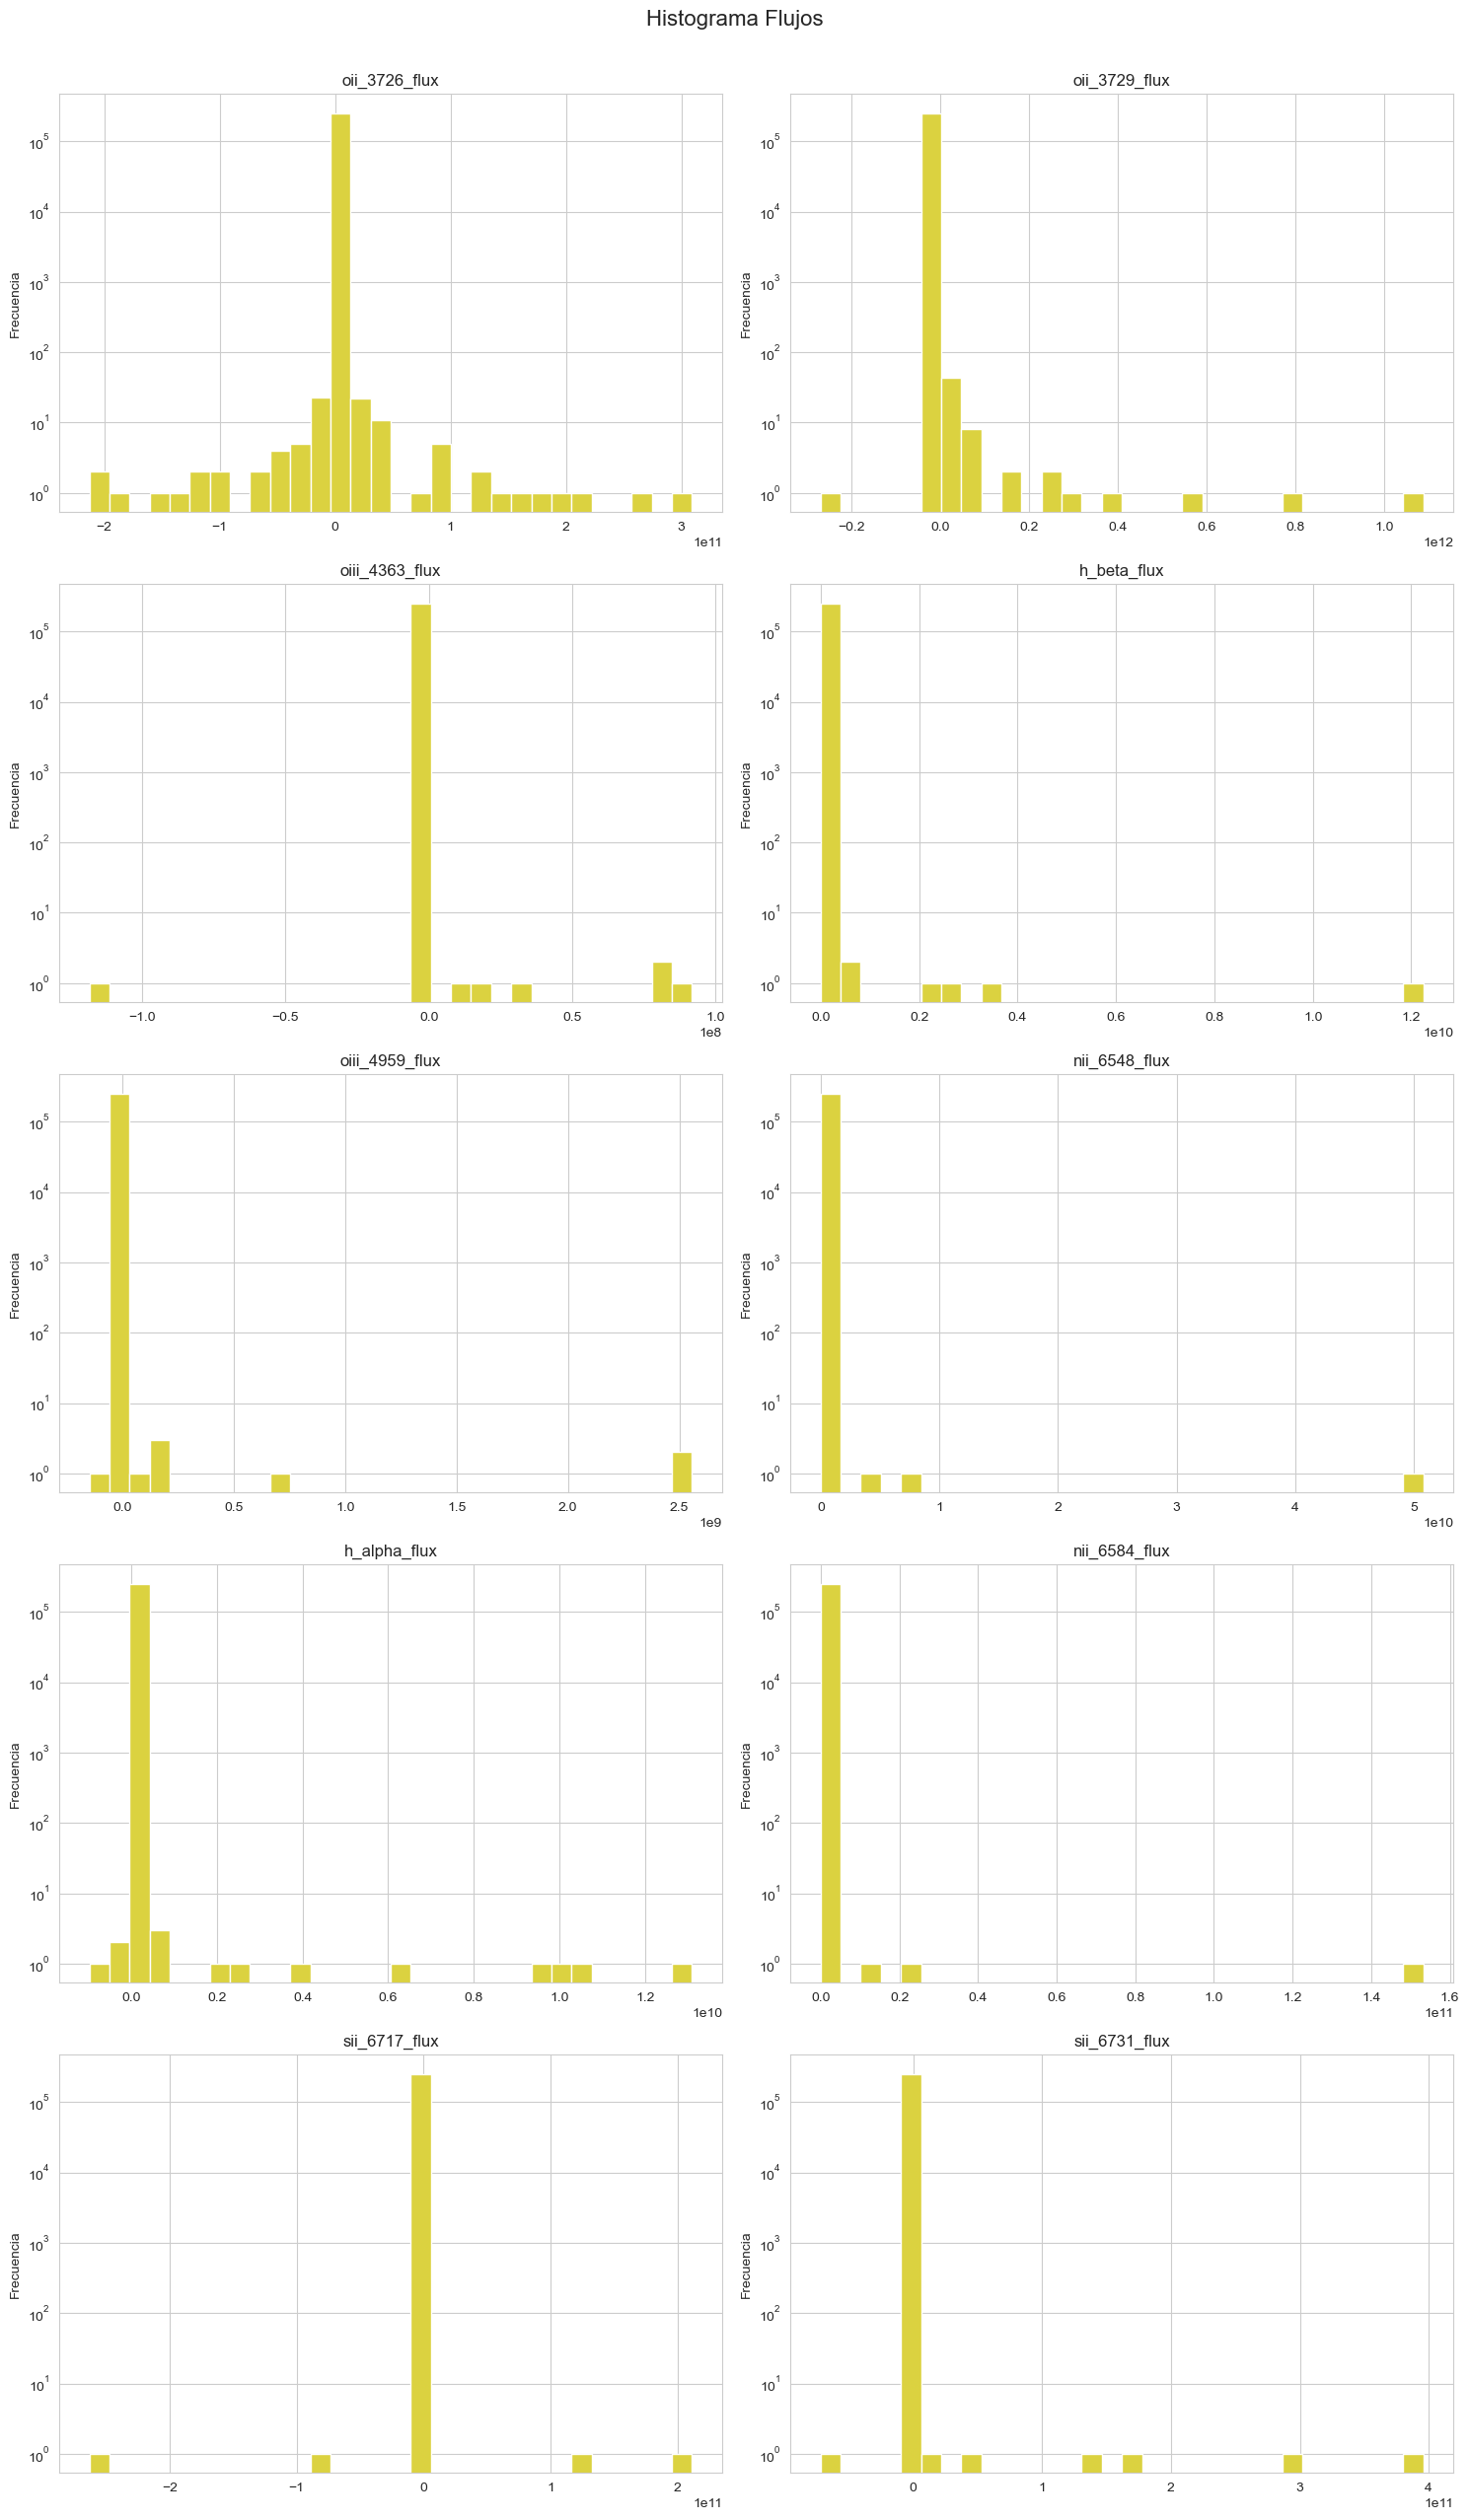

In [146]:
columns = [
    'oii_3726_flux',  'oii_3729_flux',
    'oiii_4363_flux',  'h_beta_flux', 
    'oiii_4959_flux',  'nii_6548_flux', 
    'h_alpha_flux',  'nii_6584_flux', 
    'sii_6717_flux',  'sii_6731_flux'
]

rows = (len(columns) + 1) // 2
cols = 2

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
axes = axes.flatten()  

for i, column in enumerate(columns):
    column_data = Lineas[column].to_numpy()

    axes[i].hist(column_data, bins=30, color='#DBD240', edgecolor=None) ##Debe hacerse el histograma del logaritmo
    axes[i].set_title(column)
    #axes[i].set_xlabel(column)
    axes[i].set_yscale('log')
    #axes[i].set_xscale('log')
    axes[i].set_ylabel('Frecuencia')
    axes[i].grid(True)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Histograma Flujos", y=1.02, fontsize=16)
plt.show()


/var/folders/0s/_xxgbjs554192y_2w2mspv3c0000gn/T/ipykernel_15086/11223569.py:27: RuntimeWarning: invalid value encountered in divide
  err_rel = column_data_flux / column_data_err


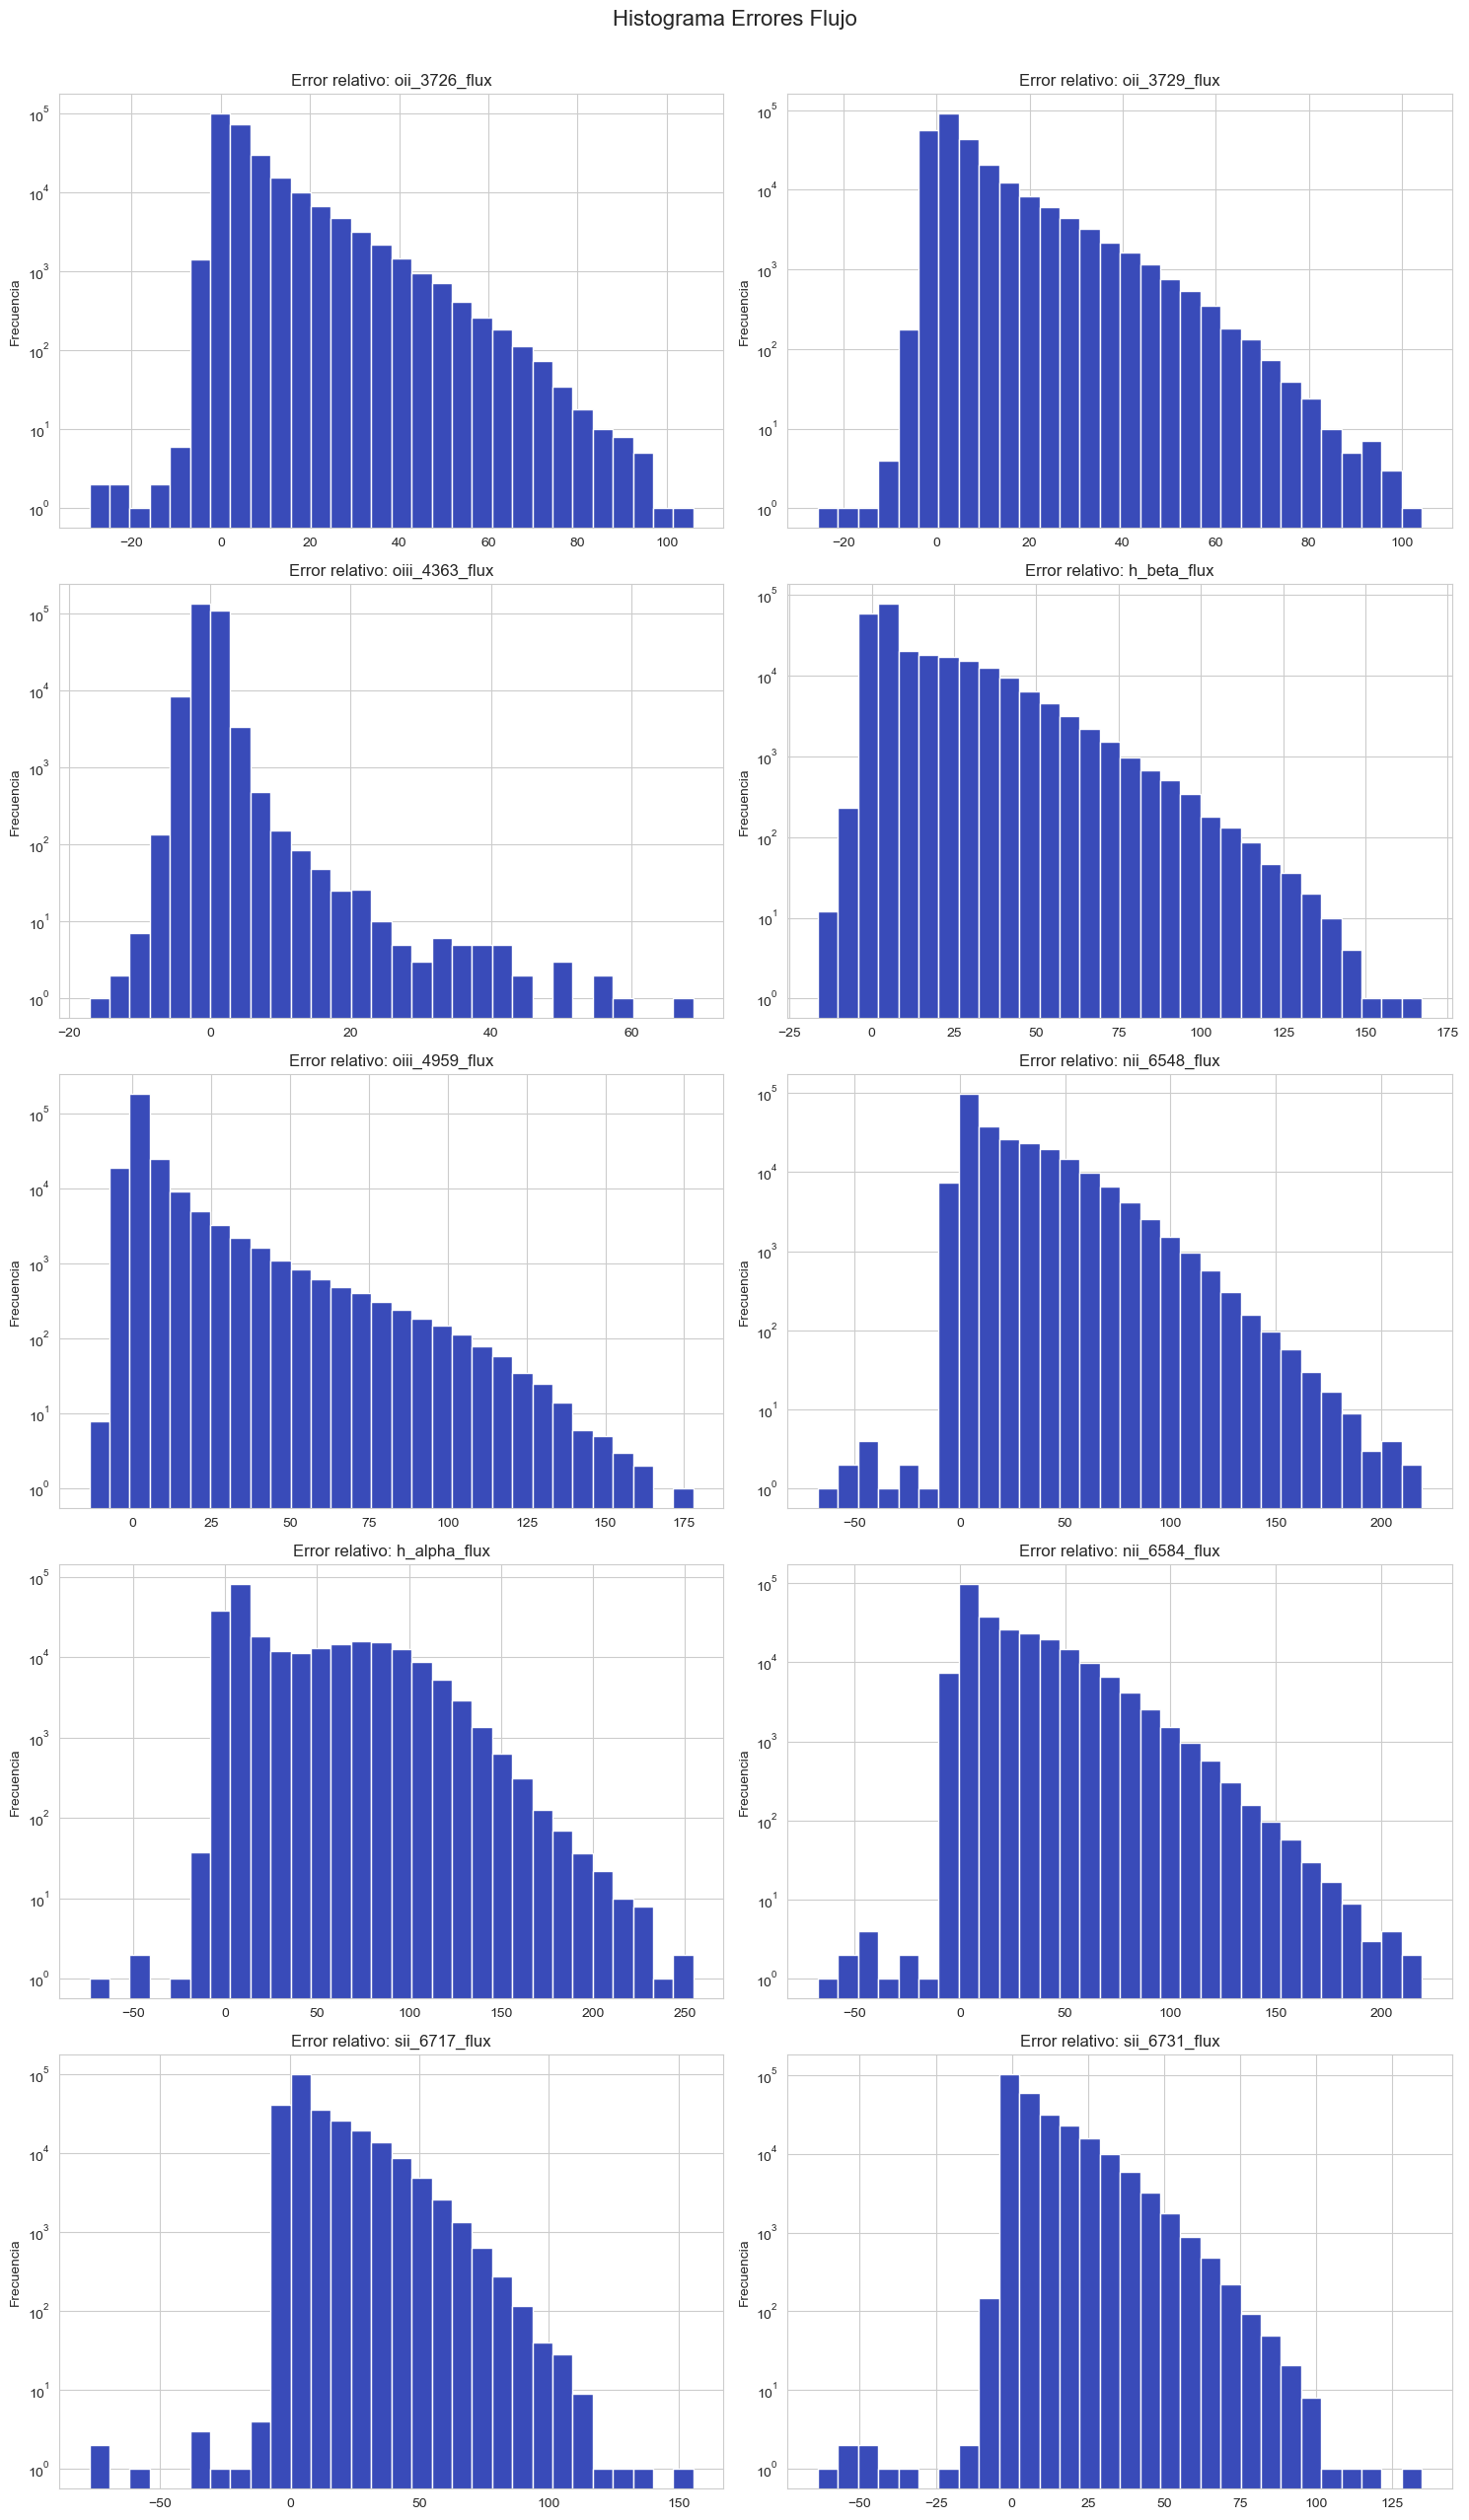

In [147]:
columns = [
    'oii_3726_flux_err',  'oii_3729_flux_err',
    'oiii_4363_flux_err',  'h_beta_flux_err', 
    'oiii_4959_flux_err',  'nii_6548_flux_err', 
    'h_alpha_flux_err',  'nii_6584_flux_err', 
    'sii_6717_flux_err',  'sii_6731_flux_err'
]
columns_1 = [
    'oii_3726_flux',  'oii_3729_flux',
    'oiii_4363_flux',  'h_beta_flux', 
    'oiii_4959_flux',  'nii_6548_flux', 
    'h_alpha_flux',  'nii_6584_flux', 
    'sii_6717_flux',  'sii_6731_flux'
]

rows = (len(columns) + 1) // 2
cols = 2

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
axes = axes.flatten()  

for i, (col_err, col_flux) in enumerate(zip(columns, columns_1)):
    column_data_err = Lineas[col_err].to_numpy()
    column_data_flux = Lineas[col_flux].to_numpy()

    #Error relativo
    err_rel = column_data_flux / column_data_err

    # Graficar la razón
    axes[i].hist(err_rel, bins=30, color='#394BB9', edgecolor=None)
    axes[i].set_title(f'Error relativo: {col_flux}')
    axes[i].set_yscale('log')
    axes[i].set_ylabel('Frecuencia')
    axes[i].grid(True)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Histograma Errores Flujo", y=1.02, fontsize=16)
plt.show()


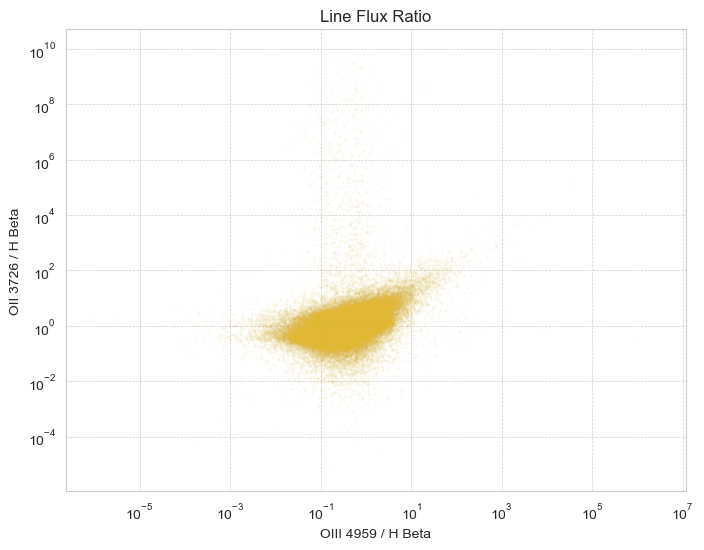

In [148]:
#### Diagramas de Diagnóstico ####

x_data = Lineas['oiii_4959_flux']/Lineas['h_beta_flux']
y_data = Lineas['oii_3726_flux']/Lineas['h_beta_flux']

plt.figure(figsize=(8, 6))
plt.plot(x_data, y_data, '.', color='#E0B834', alpha=0.5, markersize=0.2)

plt.yscale('log')
plt.xscale('log')

plt.xlabel('OIII 4959 / H Beta')
plt.ylabel('OII 3726 / H Beta')
plt.title('Line Flux Ratio')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

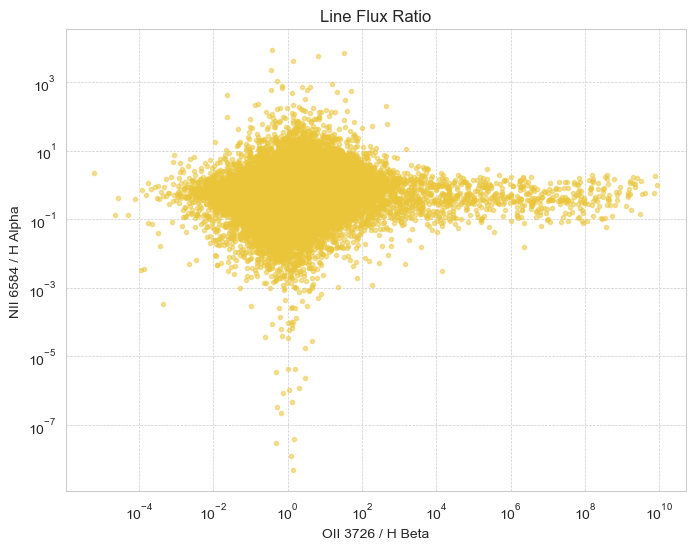

In [149]:
x_data = Lineas['oii_3726_flux'] / Lineas['h_beta_flux']
y_data = Lineas['nii_6584_flux'] / Lineas['h_alpha_flux']

plt.figure(figsize=(8, 6))
plt.plot(x_data, y_data, '.', color='#EAC539', alpha=0.5)

plt.yscale('log')
plt.xscale('log')

plt.xlabel('OII 3726 / H Beta')
plt.ylabel('NII 6584 / H Alpha')
plt.title('Line Flux Ratio')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


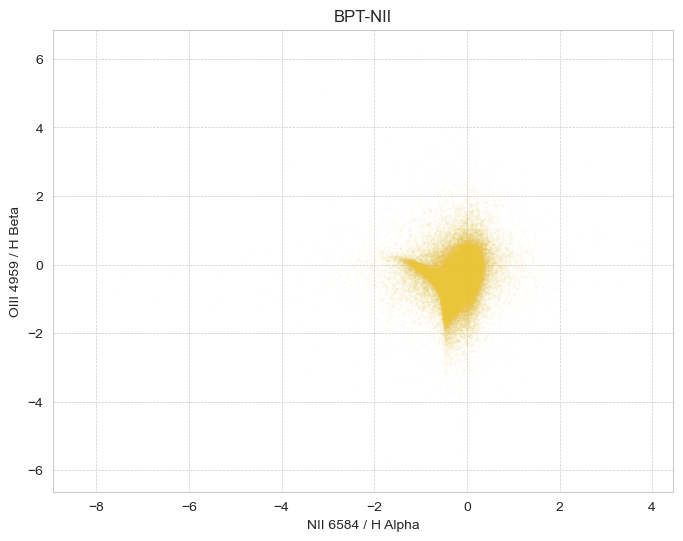

In [150]:
x_data = Lineas['nii_6584_flux'] / Lineas['h_alpha_flux']
y_data = Lineas['oiii_4959_flux'] / Lineas['h_beta_flux']

#log_x = np.linspace(np.min(x_data), np.max(x_data), 400)

# Kauffmann+03 and Kewley+01
log_y_kauffmann = 0.61 / (np.log10(x_data) - 0.05) + 1.3
log_y_kewley = 0.61 / (np.log10(x_data) - 0.47) + 1.19

plt.figure(figsize=(8, 6))
plt.plot(np.log10(x_data), np.log10(y_data), '.', color='#EAC539', alpha=0.2, label='Data', markersize=0.3)


#plt.plot(np.log10(x_data), log_y_kauffmann, '-', color='blue', label='Kauffmann+03')
#plt.plot(np.log10(x_data), log_y_kewley, '-', color='red', label='Kewley+01')
#plt.yscale('log')
#plt.xscale('log')

plt.ylabel('OIII 4959 / H Beta')
plt.xlabel('NII 6584 / H Alpha')
plt.title('BPT-NII')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

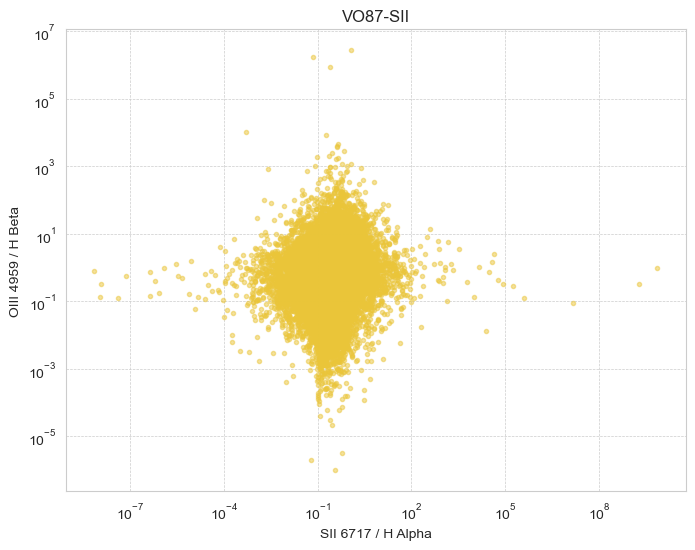

In [151]:
x_data = Lineas['sii_6717_flux'] / Lineas['h_alpha_flux']
y_data = Lineas['oiii_4959_flux'] / Lineas['h_beta_flux']

plt.figure(figsize=(8, 6))
plt.plot(x_data, y_data, '.', color='#EAC539', alpha=0.5)

plt.yscale('log')
plt.xscale('log')

plt.xlabel('SII 6717 / H Alpha')
plt.ylabel('OIII 4959 / H Beta')
plt.title('VO87-SII')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

In [72]:
###### Prueba para ver qué pasa con los signos de las lineas ####
### Galaxia: SDSS J094726.35-004832.0 ###
pd.options.display.max_columns = None

gal_prueba = pd.read_csv('Ensayo_signo_lineas.csv')
gal_prueba



oii_3726_flux  oii_3726_eqw  oii_3729_flux  oii_3729_eqw  oiii_4363_flux  \
0       34.65637     -8.543317      -19.34087     -8.543317       -4.528246   

   oiii_4363_eqw  h_beta_flux  h_beta_eqw  oiii_4959_flux  oiii_4959_eqw  \
0       1.019589     6.541351   -0.420018       -1.394262       2.898594   

   oiii_5007_flux  oiii_5007_eqw  hei_5876_flux  hei_5876_eqw  oi_6300_flux  \
0        19.52857      -2.303802      -41.76477      0.408013      1.590457   

   oi_6300_eqw  nii_6548_flux  nii_6548_eqw  h_alpha_flux  h_alpha_eqw  \
0    -0.385188       3.858758     -0.438322      18.46744    -1.110524   

   nii_6584_flux  nii_6584_eqw  sii_6717_flux  sii_6717_eqw  sii_6731_flux  \
0        11.6389     -1.139431       11.04219     -0.399588       6.273335   

   sii_6731_eqw           specObjId  reliable  
0     -0.949206  299490501608892416         1

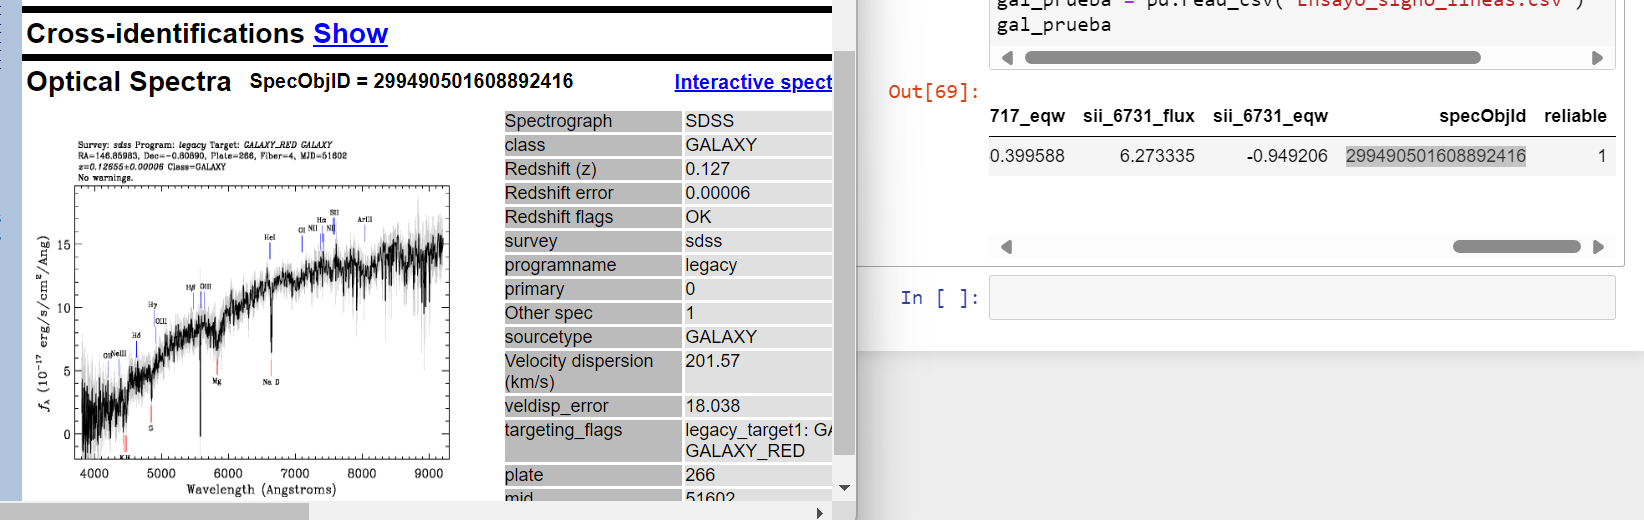